In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)
import os
%cd /kaggle/input/champs-scalar-coupling
print(os.listdir("."))

[Errno 2] No such file or directory: '/kaggle/input/champs-scalar-coupling'
/home/nagae/kaggle/competitions/champs-scalar-coupling/code
['feature_engineering_NN.ipynb', 'molecule_model_2JHC.hdf5', 'molecule_model_2JHN.hdf5', 'molecule_model_1JHN.hdf5', 'svm.ipynb', 'molecule_model_1JHC.hdf5', 'molecule_model_3JHH.hdf5', 'molecule_model_3JHC.hdf5', 'workingsubmission-test.csv', 'feature_engineering_NN-Copy1.ipynb', 'xgboost.ipynb', 'molecule_model_2JHH.hdf5', 'molecule_model_3JHN.hdf5', 'feature_engineer.ipynb', 'predict.ipynb', 'DeepLearning.ipynb', '.ipynb_checkpoints']


Using TensorFlow backend.


In [2]:
df_train=pd.read_csv('../input/train.csv')
df_test=pd.read_csv('../input/test.csv')
df_struct=pd.read_csv('../input/structures.csv')

#df_train_sub_potential=pd.read_csv('/content/champs/potential_energy.csv')
#df_train_sub_moment=pd.read_csv('../input/dipole_moments.csv')
df_train_sub_charge=pd.read_csv('../input/mulliken_charges.csv')
df_train_sub_tensor=pd.read_csv('../input/magnetic_shielding_tensors.csv')

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
print(df_train.shape, df_test.shape, df_struct.shape, df_train_sub_charge.shape, df_train_sub_tensor.shape)
#df_train = reduce_mem_usage(df_train)
#df_test = reduce_mem_usage(df_test)
#df_struct = reduce_mem_usage(df_struct)
#df_train_sub_charge = reduce_mem_usage(df_train_sub_charge)
#df_train_sub_tensor = reduce_mem_usage(df_train_sub_tensor)
print(df_train.shape, df_test.shape, df_struct.shape, df_train_sub_charge.shape, df_train_sub_tensor.shape)

(4658147, 6) (2505542, 5) (2358657, 6) (1533537, 3) (1533537, 11)
(4658147, 6) (2505542, 5) (2358657, 6) (1533537, 3) (1533537, 11)


In [4]:
import psutil
import os

def map_atom_info(df_1,df_2, atom_idx):
    print('Mapping...', df_1.shape, df_2.shape, atom_idx)
    
    df = pd.merge(df_1, df_2.drop_duplicates(subset=['molecule_name', 'atom_index']), how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)

    return df

def show_ram_usage():
    py = psutil.Process(os.getpid())
    print('RAM usage: {} GB'.format(py.memory_info()[0]/2. ** 30))

show_ram_usage()

for atom_idx in [0,1]:
    df_train = map_atom_info(df_train,df_struct, atom_idx)
    df_train = map_atom_info(df_train,df_train_sub_charge, atom_idx)
    df_train = map_atom_info(df_train,df_train_sub_tensor, atom_idx)
    df_train = df_train.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}',
                                        'mulliken_charge': f'charge_{atom_idx}',
                                        'XX': f'XX_{atom_idx}',
                                        'YX': f'YX_{atom_idx}',
                                        'ZX': f'ZX_{atom_idx}',
                                        'XY': f'XY_{atom_idx}',
                                        'YY': f'YY_{atom_idx}',
                                        'ZY': f'ZY_{atom_idx}',
                                        'XZ': f'XZ_{atom_idx}',
                                        'YZ': f'YZ_{atom_idx}',
                                        'ZZ': f'ZZ_{atom_idx}',})
    df_test = map_atom_info(df_test,df_struct, atom_idx)
    df_test = df_test.rename(columns={'atom': f'atom_{atom_idx}',
                                'x': f'x_{atom_idx}',
                                'y': f'y_{atom_idx}',
                                'z': f'z_{atom_idx}'})
    #add some features
    
    df_struct['c_x']=df_struct.groupby('molecule_name')['x'].transform('mean')
    df_struct['c_y']=df_struct.groupby('molecule_name')['y'].transform('mean')
    df_struct['c_z']=df_struct.groupby('molecule_name')['z'].transform('mean')
    df_struct['atom_n']=df_struct.groupby('molecule_name')['atom_index'].transform('max')
    
    show_ram_usage()
    print(df_train.shape, df_test.shape)

RAM usage: 1.0292892456054688 GB
Mapping... (4658147, 6) (2358657, 6) 0
Mapping... (4658147, 10) (1533537, 3) 0
Mapping... (4658147, 11) (1533537, 11) 0
Mapping... (2505542, 5) (2358657, 6) 0
RAM usage: 1.7315750122070312 GB
(4658147, 20) (2505542, 9)
Mapping... (4658147, 20) (2358657, 10) 1
Mapping... (4658147, 28) (1533537, 3) 1
Mapping... (4658147, 29) (1533537, 11) 1
Mapping... (2505542, 9) (2358657, 10) 1
RAM usage: 2.523284912109375 GB
(4658147, 38) (2505542, 17)


In [5]:
def make_features(df):
    df['dx']=df['x_1']-df['x_0']
    df['dy']=df['y_1']-df['y_0']
    df['dz']=df['z_1']-df['z_0']
    df['distance']=(df['dx']**2+df['dy']**2+df['dz']**2)**(1/2)
    return df

df_train=make_features(df_train)
df_test=make_features(df_test) 
#df_train = reduce_mem_usage(df_train)
#df_test = reduce_mem_usage(df_test)
test_prediction=np.zeros(len(df_test))
show_ram_usage()
print(df_train.shape, df_test.shape)

def get_dist(df):
    df_temp=df.loc[:,["molecule_name","atom_index_0","atom_index_1","distance","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
    df_temp_all=pd.concat((df_temp,df_temp_),axis=0)

    df_temp_all["min_distance"]=df_temp_all.groupby(['molecule_name', 'atom_index_0'])['distance'].transform('min')
    df_temp_all["max_distance"]=df_temp_all.groupby(['molecule_name', 'atom_index_0'])['distance'].transform('max')
    
    df_temp= df_temp_all[df_temp_all["min_distance"]==df_temp_all["distance"]].copy()
    df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                         'atom_index_1': 'atom_index_closest',
                                         'distance': 'distance_closest',
                                         'x_1': 'x_closest',
                                         'y_1': 'y_closest',
                                         'z_1': 'z_closest'})
    
    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})
        
    df_temp= df_temp_all[df_temp_all["max_distance"]==df_temp_all["distance"]].copy()
    df_temp=df_temp.drop(['x_0','y_0','z_0','max_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                         'atom_index_1': 'atom_index_farthest',
                                         'distance': 'distance_farthest',
                                         'x_1': 'x_farthest',
                                         'y_1': 'y_farthest',
                                         'z_1': 'z_farthest'})
        
    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_farthest': f'atom_index_farthest_{atom_idx}',
                                        'distance_farthest': f'distance_farthest_{atom_idx}',
                                        'x_farthest': f'x_farthest_{atom_idx}',
                                        'y_farthest': f'y_farthest_{atom_idx}',
                                        'z_farthest': f'z_farthest_{atom_idx}'})
    return df
df_test=(get_dist(df_test))    
df_train=(get_dist(df_train)) 

print(df_train.shape, df_test.shape)
show_ram_usage()


RAM usage: 2.700439453125 GB
(4658147, 42) (2505542, 21)
Mapping... (2505542, 21) (756113, 8) 0
Mapping... (2505542, 27) (756113, 8) 1
Mapping... (2505542, 33) (756113, 8) 0
Mapping... (2505542, 39) (756113, 8) 1
Mapping... (4658147, 42) (1405128, 8) 0
Mapping... (4658147, 48) (1405128, 8) 1
Mapping... (4658147, 54) (1405130, 8) 0
Mapping... (4658147, 60) (1405130, 8) 1
(4658147, 66) (2505542, 45)
RAM usage: 4.280681610107422 GB


In [6]:
def add_features(df):
    df["distance_center0"]=((df['x_0']-df['c_x'])**2+(df['y_0']-df['c_y'])**2+(df['z_0']-df['c_z'])**2)**(1/2)
    df["distance_center1"]=((df['x_1']-df['c_x'])**2+(df['y_1']-df['c_y'])**2+(df['z_1']-df['c_z'])**2)**(1/2)
    df["distance_c0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_c1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["distance_f0"]=((df['x_0']-df['x_farthest_0'])**2+(df['y_0']-df['y_farthest_0'])**2+(df['z_0']-df['z_farthest_0'])**2)**(1/2)
    df["distance_f1"]=((df['x_1']-df['x_farthest_1'])**2+(df['y_1']-df['y_farthest_1'])**2+(df['z_1']-df['z_farthest_1'])**2)**(1/2)
    df["vec_center0_x"]=(df['x_0']-df['c_x'])/(df["distance_center0"]+1e-10)
    df["vec_center0_y"]=(df['y_0']-df['c_y'])/(df["distance_center0"]+1e-10)
    df["vec_center0_z"]=(df['z_0']-df['c_z'])/(df["distance_center0"]+1e-10)
    df["vec_center1_x"]=(df['x_1']-df['c_x'])/(df["distance_center1"]+1e-10)
    df["vec_center1_y"]=(df['y_1']-df['c_y'])/(df["distance_center1"]+1e-10)
    df["vec_center1_z"]=(df['z_1']-df['c_z'])/(df["distance_center1"]+1e-10)
    df["vec_c0_x"]=(df['x_0']-df['x_closest_0'])/(df["distance_c0"]+1e-10)
    df["vec_c0_y"]=(df['y_0']-df['y_closest_0'])/(df["distance_c0"]+1e-10)
    df["vec_c0_z"]=(df['z_0']-df['z_closest_0'])/(df["distance_c0"]+1e-10)
    df["vec_c1_x"]=(df['x_1']-df['x_closest_1'])/(df["distance_c1"]+1e-10)
    df["vec_c1_y"]=(df['y_1']-df['y_closest_1'])/(df["distance_c1"]+1e-10)
    df["vec_c1_z"]=(df['z_1']-df['z_closest_1'])/(df["distance_c1"]+1e-10)
    df["vec_f0_x"]=(df['x_0']-df['x_farthest_0'])/(df["distance_f0"]+1e-10)
    df["vec_f0_y"]=(df['y_0']-df['y_farthest_0'])/(df["distance_f0"]+1e-10)
    df["vec_f0_z"]=(df['z_0']-df['z_farthest_0'])/(df["distance_f0"]+1e-10)
    df["vec_f1_x"]=(df['x_1']-df['x_farthest_1'])/(df["distance_f1"]+1e-10)
    df["vec_f1_y"]=(df['y_1']-df['y_farthest_1'])/(df["distance_f1"]+1e-10)
    df["vec_f1_z"]=(df['z_1']-df['z_farthest_1'])/(df["distance_f1"]+1e-10)
    df["vec_x"]=(df['x_1']-df['x_0'])/df["distance"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["distance"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["distance"]
    df["cos_c0_c1"]=df["vec_c0_x"]*df["vec_c1_x"]+df["vec_c0_y"]*df["vec_c1_y"]+df["vec_c0_z"]*df["vec_c1_z"]
    df["cos_f0_f1"]=df["vec_f0_x"]*df["vec_f1_x"]+df["vec_f0_y"]*df["vec_f1_y"]+df["vec_f0_z"]*df["vec_f1_z"]
    df["cos_center0_center1"]=df["vec_center0_x"]*df["vec_center1_x"]+df["vec_center0_y"]*df["vec_center1_y"]+df["vec_center0_z"]*df["vec_center1_z"]
    df["cos_c0"]=df["vec_c0_x"]*df["vec_x"]+df["vec_c0_y"]*df["vec_y"]+df["vec_c0_z"]*df["vec_z"]
    df["cos_c1"]=df["vec_c1_x"]*df["vec_x"]+df["vec_c1_y"]*df["vec_y"]+df["vec_c1_z"]*df["vec_z"]
    df["cos_f0"]=df["vec_f0_x"]*df["vec_x"]+df["vec_f0_y"]*df["vec_y"]+df["vec_f0_z"]*df["vec_z"]
    df["cos_f1"]=df["vec_f1_x"]*df["vec_x"]+df["vec_f1_y"]*df["vec_y"]+df["vec_f1_z"]*df["vec_z"]
    df["cos_center0"]=df["vec_center0_x"]*df["vec_x"]+df["vec_center0_y"]*df["vec_y"]+df["vec_center0_z"]*df["vec_z"]
    df["cos_center1"]=df["vec_center1_x"]*df["vec_x"]+df["vec_center1_y"]*df["vec_y"]+df["vec_center1_z"]*df["vec_z"]
    df=df.drop(['vec_c0_x','vec_c0_y','vec_c0_z','vec_c1_x','vec_c1_y','vec_c1_z',
                'vec_f0_x','vec_f0_y','vec_f0_z','vec_f1_x','vec_f1_y','vec_f1_z',
                'vec_center0_x','vec_center0_y','vec_center0_z','vec_center1_x','vec_center1_y','vec_center1_z',
                'vec_x','vec_y','vec_z'], axis=1)
    return df
    
df_train=add_features(df_train)
df_test=add_features(df_test)
print(df_train.shape, df_test.shape)
show_ram_usage()

(4658147, 81) (2505542, 60)
RAM usage: 4.9433135986328125 GB


In [7]:
def create_nn_model(input_shape):
    inp = Input(shape=(input_shape,))
    x = Dense(256)(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.4)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.2)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.2)(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.4)(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    #x = Dropout(0.4)(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.4)(x)
    out1 = Dense(2, activation="linear")(x)#mulliken charge 2
    out2 = Dense(6, activation="linear")(x)#tensor 6(xx,yy,zz)
    out3 = Dense(12, activation="linear")(x)#tensor 12(others) 
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.2)(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation="linear")(x)#scalar_coupling_constant    
    model = Model(inputs=inp, outputs=[out,out1,out2,out3])
    return model

In [8]:
def plot_history(history, label):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

Training 1JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 638474 samples, validate on 70942 samples
Epoch 1/300
638474/638474 [==============================] - 27s 43us/step - loss: 47.1272 - dense_13_loss: 43.4359 - dense_7_loss: 0.5545 - dense_8_loss: 2.4013 - dense_9_loss: 0.7355 - val_loss: 8.1256 - val_dense_13_loss: 4.7019 - val_dense_7_loss: 0.4733 - val_dense_8_loss: 2.2357 - val_dense_9_loss: 0.7147
Epoch 2/300
638474/638474 [==============================] - 25s 39us/step - loss: 11.0202 - dense_13_loss: 7.5343 - dense_7_loss: 0.4953 - dense_8_loss: 2.2769 - dense_9_loss: 0.7137 - val_loss: 7.0062 - val_dense_13_loss: 3.7358 - val_dense_7_loss: 0.4371 - val_dense_8_loss: 2.1189 - val_dense_9_loss: 0.7144
Epoch 3/

Epoch 24/300
638474/638474 [==============================] - 25s 39us/step - loss: 8.5106 - dense_13_loss: 5.4933 - dense_7_loss: 0.3789 - dense_8_loss: 1.9256 - dense_9_loss: 0.7128 - val_loss: 5.6637 - val_dense_13_loss: 2.8416 - val_dense_7_loss: 0.3205 - val_dense_8_loss: 1.7876 - val_dense_9_loss: 0.7139
Epoch 25/300
638474/638474 [==============================] - 25s 39us/step - loss: 8.4677 - dense_13_loss: 5.4594 - dense_7_loss: 0.3763 - dense_8_loss: 1.9192 - dense_9_loss: 0.7128 - val_loss: 5.5768 - val_dense_13_loss: 2.7690 - val_dense_7_loss: 0.3176 - val_dense_8_loss: 1.7762 - val_dense_9_loss: 0.7140
Epoch 26/300
638474/638474 [==============================] - 25s 39us/step - loss: 8.4371 - dense_13_loss: 5.4341 - dense_7_loss: 0.3758 - dense_8_loss: 1.9145 - dense_9_loss: 0.7128 - val_loss: 5.6337 - val_dense_13_loss: 2.8239 - val_dense_7_loss: 0.3183 - val_dense_8_loss: 1.7776 - val_dense_9_loss: 0.7139
Epoch 27/300
638474/638474 [==============================] - 25

638474/638474 [==============================] - 25s 38us/step - loss: 7.7426 - dense_13_loss: 4.8354 - dense_7_loss: 0.3534 - dense_8_loss: 1.8412 - dense_9_loss: 0.7126 - val_loss: 5.2399 - val_dense_13_loss: 2.5557 - val_dense_7_loss: 0.2896 - val_dense_8_loss: 1.6808 - val_dense_9_loss: 0.7138
Epoch 51/300
638474/638474 [==============================] - 25s 39us/step - loss: 7.7184 - dense_13_loss: 4.8154 - dense_7_loss: 0.3525 - dense_8_loss: 1.8379 - dense_9_loss: 0.7126 - val_loss: 5.2910 - val_dense_13_loss: 2.6079 - val_dense_7_loss: 0.2909 - val_dense_8_loss: 1.6784 - val_dense_9_loss: 0.7138
Epoch 52/300
638474/638474 [==============================] - 25s 39us/step - loss: 7.7151 - dense_13_loss: 4.8078 - dense_7_loss: 0.3533 - dense_8_loss: 1.8414 - dense_9_loss: 0.7126 - val_loss: 5.1939 - val_dense_13_loss: 2.5158 - val_dense_7_loss: 0.2897 - val_dense_8_loss: 1.6747 - val_dense_9_loss: 0.7137
Epoch 53/300
638474/638474 [==============================] - 25s 39us/step -

638474/638474 [==============================] - 25s 39us/step - loss: 7.1678 - dense_13_loss: 4.3163 - dense_7_loss: 0.3410 - dense_8_loss: 1.7979 - dense_9_loss: 0.7125 - val_loss: 5.0016 - val_dense_13_loss: 2.3818 - val_dense_7_loss: 0.2770 - val_dense_8_loss: 1.6292 - val_dense_9_loss: 0.7136
Epoch 77/300
638474/638474 [==============================] - 25s 39us/step - loss: 7.1564 - dense_13_loss: 4.3051 - dense_7_loss: 0.3405 - dense_8_loss: 1.7982 - dense_9_loss: 0.7126 - val_loss: 4.9681 - val_dense_13_loss: 2.3485 - val_dense_7_loss: 0.2764 - val_dense_8_loss: 1.6294 - val_dense_9_loss: 0.7139
Epoch 78/300
638474/638474 [==============================] - 25s 39us/step - loss: 7.1382 - dense_13_loss: 4.2895 - dense_7_loss: 0.3403 - dense_8_loss: 1.7959 - dense_9_loss: 0.7125 - val_loss: 4.9694 - val_dense_13_loss: 2.3560 - val_dense_7_loss: 0.2760 - val_dense_8_loss: 1.6237 - val_dense_9_loss: 0.7137
Epoch 79/300
638474/638474 [==============================] - 25s 39us/step -

638474/638474 [==============================] - 24s 38us/step - loss: 6.7104 - dense_13_loss: 3.8931 - dense_7_loss: 0.3337 - dense_8_loss: 1.7711 - dense_9_loss: 0.7125 - val_loss: 4.8686 - val_dense_13_loss: 2.2947 - val_dense_7_loss: 0.2694 - val_dense_8_loss: 1.5909 - val_dense_9_loss: 0.7136
Epoch 103/300
638474/638474 [==============================] - 24s 38us/step - loss: 6.6981 - dense_13_loss: 3.8820 - dense_7_loss: 0.3335 - dense_8_loss: 1.7701 - dense_9_loss: 0.7125 - val_loss: 4.8211 - val_dense_13_loss: 2.2437 - val_dense_7_loss: 0.2694 - val_dense_8_loss: 1.5944 - val_dense_9_loss: 0.7136
Epoch 104/300
638474/638474 [==============================] - 25s 38us/step - loss: 6.6888 - dense_13_loss: 3.8714 - dense_7_loss: 0.3338 - dense_8_loss: 1.7712 - dense_9_loss: 0.7125 - val_loss: 4.8510 - val_dense_13_loss: 2.2826 - val_dense_7_loss: 0.2673 - val_dense_8_loss: 1.5874 - val_dense_9_loss: 0.7136
Epoch 105/300
638474/638474 [==============================] - 24s 38us/ste

638474/638474 [==============================] - 25s 39us/step - loss: 6.3349 - dense_13_loss: 3.5408 - dense_7_loss: 0.3286 - dense_8_loss: 1.7530 - dense_9_loss: 0.7125 - val_loss: 4.7529 - val_dense_13_loss: 2.2024 - val_dense_7_loss: 0.2646 - val_dense_8_loss: 1.5723 - val_dense_9_loss: 0.7136
Epoch 129/300
638474/638474 [==============================] - 25s 39us/step - loss: 6.3230 - dense_13_loss: 3.5275 - dense_7_loss: 0.3287 - dense_8_loss: 1.7544 - dense_9_loss: 0.7125 - val_loss: 4.7516 - val_dense_13_loss: 2.2083 - val_dense_7_loss: 0.2619 - val_dense_8_loss: 1.5677 - val_dense_9_loss: 0.7137
Epoch 130/300
638474/638474 [==============================] - 25s 39us/step - loss: 6.3131 - dense_13_loss: 3.5199 - dense_7_loss: 0.3285 - dense_8_loss: 1.7522 - dense_9_loss: 0.7125 - val_loss: 4.7288 - val_dense_13_loss: 2.1842 - val_dense_7_loss: 0.2619 - val_dense_8_loss: 1.5690 - val_dense_9_loss: 0.7138
Epoch 131/300
638474/638474 [==============================] - 25s 39us/ste

638474/638474 [==============================] - 25s 40us/step - loss: 6.0322 - dense_13_loss: 3.2553 - dense_7_loss: 0.3249 - dense_8_loss: 1.7395 - dense_9_loss: 0.7125 - val_loss: 4.6496 - val_dense_13_loss: 2.1284 - val_dense_7_loss: 0.2582 - val_dense_8_loss: 1.5494 - val_dense_9_loss: 0.7136
Epoch 155/300
638474/638474 [==============================] - 25s 39us/step - loss: 6.0180 - dense_13_loss: 3.2411 - dense_7_loss: 0.3249 - dense_8_loss: 1.7396 - dense_9_loss: 0.7125 - val_loss: 4.6329 - val_dense_13_loss: 2.1104 - val_dense_7_loss: 0.2594 - val_dense_8_loss: 1.5494 - val_dense_9_loss: 0.7137
Epoch 156/300
638474/638474 [==============================] - 25s 39us/step - loss: 6.0212 - dense_13_loss: 3.2445 - dense_7_loss: 0.3248 - dense_8_loss: 1.7394 - dense_9_loss: 0.7125 - val_loss: 4.7878 - val_dense_13_loss: 2.2651 - val_dense_7_loss: 0.2592 - val_dense_8_loss: 1.5499 - val_dense_9_loss: 0.7136
Epoch 157/300
638474/638474 [==============================] - 25s 39us/ste

Epoch 180/300
638474/638474 [==============================] - 25s 39us/step - loss: 5.8026 - dense_13_loss: 3.0585 - dense_7_loss: 0.3181 - dense_8_loss: 1.7142 - dense_9_loss: 0.7118 - val_loss: 4.5497 - val_dense_13_loss: 2.0584 - val_dense_7_loss: 0.2520 - val_dense_8_loss: 1.5260 - val_dense_9_loss: 0.7132
Epoch 181/300
638474/638474 [==============================] - 25s 39us/step - loss: 5.8020 - dense_13_loss: 3.0585 - dense_7_loss: 0.3173 - dense_8_loss: 1.7145 - dense_9_loss: 0.7118 - val_loss: 4.5375 - val_dense_13_loss: 2.0485 - val_dense_7_loss: 0.2514 - val_dense_8_loss: 1.5243 - val_dense_9_loss: 0.7133
Epoch 182/300
638474/638474 [==============================] - 25s 39us/step - loss: 5.7917 - dense_13_loss: 3.0481 - dense_7_loss: 0.3178 - dense_8_loss: 1.7141 - dense_9_loss: 0.7118 - val_loss: 4.5474 - val_dense_13_loss: 2.0561 - val_dense_7_loss: 0.2521 - val_dense_8_loss: 1.5259 - val_dense_9_loss: 0.7132
Epoch 183/300
638474/638474 [==============================] 

638474/638474 [==============================] - 25s 39us/step - loss: 5.7435 - dense_13_loss: 3.0059 - dense_7_loss: 0.3160 - dense_8_loss: 1.7099 - dense_9_loss: 0.7118 - val_loss: 4.5242 - val_dense_13_loss: 2.0393 - val_dense_7_loss: 0.2510 - val_dense_8_loss: 1.5207 - val_dense_9_loss: 0.7133
Epoch 207/300
638474/638474 [==============================] - 25s 39us/step - loss: 5.7472 - dense_13_loss: 3.0095 - dense_7_loss: 0.3160 - dense_8_loss: 1.7100 - dense_9_loss: 0.7118 - val_loss: 4.5226 - val_dense_13_loss: 2.0386 - val_dense_7_loss: 0.2507 - val_dense_8_loss: 1.5199 - val_dense_9_loss: 0.7132
Epoch 208/300
638474/638474 [==============================] - 25s 39us/step - loss: 5.7437 - dense_13_loss: 3.0058 - dense_7_loss: 0.3163 - dense_8_loss: 1.7098 - dense_9_loss: 0.7118 - val_loss: 4.5377 - val_dense_13_loss: 2.0547 - val_dense_7_loss: 0.2506 - val_dense_8_loss: 1.5191 - val_dense_9_loss: 0.7132
Epoch 209/300
638474/638474 [==============================] - 25s 39us/ste

638474/638474 [==============================] - 25s 39us/step - loss: 5.7111 - dense_13_loss: 2.9765 - dense_7_loss: 0.3156 - dense_8_loss: 1.7072 - dense_9_loss: 0.7118 - val_loss: 4.5218 - val_dense_13_loss: 2.0433 - val_dense_7_loss: 0.2498 - val_dense_8_loss: 1.5155 - val_dense_9_loss: 0.7132
Epoch 233/300
638474/638474 [==============================] - 25s 40us/step - loss: 5.7082 - dense_13_loss: 2.9745 - dense_7_loss: 0.3155 - dense_8_loss: 1.7064 - dense_9_loss: 0.7118 - val_loss: 4.5045 - val_dense_13_loss: 2.0255 - val_dense_7_loss: 0.2498 - val_dense_8_loss: 1.5159 - val_dense_9_loss: 0.7132
Epoch 234/300
638474/638474 [==============================] - 25s 39us/step - loss: 5.7061 - dense_13_loss: 2.9725 - dense_7_loss: 0.3155 - dense_8_loss: 1.7063 - dense_9_loss: 0.7118 - val_loss: 4.5310 - val_dense_13_loss: 2.0530 - val_dense_7_loss: 0.2494 - val_dense_8_loss: 1.5154 - val_dense_9_loss: 0.7132
Epoch 235/300
638474/638474 [==============================] - 25s 39us/ste

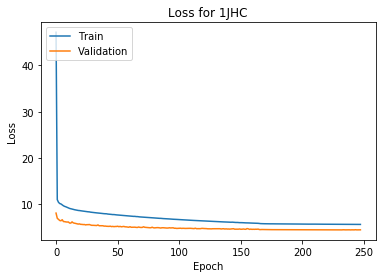

Training 2JHH out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 340232 samples, validate on 37804 samples
Epoch 1/300
340232/340232 [==============================] - 16s 47us/step - loss: 6.9660 - dense_13_loss: 2.8962 - dense_7_loss: 0.4340 - dense_8_loss: 2.8017 - dense_9_loss: 0.8341 - val_loss: 4.5675 - val_dense_13_loss: 0.9271 - val_dense_7_loss: 0.3188 - val_dense_8_loss: 2.5217 - val_dense_9_loss: 0.8000
Epoch 2/300
340232/340232 [==============================] - 13s 38us/step - loss: 4.9460 - dense_13_loss: 1.1979 - dense_7_loss: 0.3505 - dense_8_loss: 2.5978 - dense_9_loss: 0.7997 - val_loss: 4.2042 - val_dense_13_loss: 0.6796 - val_dense_7_loss: 0.3034 - val_dense_8_loss: 2.4220 - val_dense_9_loss: 0.7992
Epoch 3/300
340232/340232 [==============================] - 13s 39us/step - loss: 4.7811 - dense_13_loss: 1.1182 - dense_7_loss: 0.3341 - dense_8_loss: 2.5296 - dense_9_loss: 0.7992 - val_loss: 4.0890 - val_dense_13_loss: 0.6419 - val_dense_7_lo

Epoch 27/300
340232/340232 [==============================] - 13s 39us/step - loss: 3.9838 - dense_13_loss: 0.7271 - dense_7_loss: 0.2709 - dense_8_loss: 2.1878 - dense_9_loss: 0.7981 - val_loss: 3.4137 - val_dense_13_loss: 0.4264 - val_dense_7_loss: 0.2152 - val_dense_8_loss: 1.9739 - val_dense_9_loss: 0.7981
Epoch 28/300
340232/340232 [==============================] - 13s 39us/step - loss: 3.9670 - dense_13_loss: 0.7165 - dense_7_loss: 0.2694 - dense_8_loss: 2.1830 - dense_9_loss: 0.7981 - val_loss: 3.4205 - val_dense_13_loss: 0.4373 - val_dense_7_loss: 0.2169 - val_dense_8_loss: 1.9684 - val_dense_9_loss: 0.7980
Epoch 29/300
340232/340232 [==============================] - 13s 39us/step - loss: 3.9529 - dense_13_loss: 0.7068 - dense_7_loss: 0.2699 - dense_8_loss: 2.1782 - dense_9_loss: 0.7980 - val_loss: 3.4131 - val_dense_13_loss: 0.4252 - val_dense_7_loss: 0.2204 - val_dense_8_loss: 1.9696 - val_dense_9_loss: 0.7980
Epoch 30/300
340232/340232 [==============================] - 13

340232/340232 [==============================] - 13s 39us/step - loss: 3.7614 - dense_13_loss: 0.6029 - dense_7_loss: 0.2597 - dense_8_loss: 2.1011 - dense_9_loss: 0.7976 - val_loss: 3.2464 - val_dense_13_loss: 0.3776 - val_dense_7_loss: 0.2049 - val_dense_8_loss: 1.8661 - val_dense_9_loss: 0.7977
Epoch 54/300
340232/340232 [==============================] - 13s 39us/step - loss: 3.7554 - dense_13_loss: 0.6003 - dense_7_loss: 0.2597 - dense_8_loss: 2.0977 - dense_9_loss: 0.7977 - val_loss: 3.2526 - val_dense_13_loss: 0.3848 - val_dense_7_loss: 0.2069 - val_dense_8_loss: 1.8633 - val_dense_9_loss: 0.7976
Epoch 55/300
340232/340232 [==============================] - 13s 39us/step - loss: 3.7498 - dense_13_loss: 0.5976 - dense_7_loss: 0.2590 - dense_8_loss: 2.0955 - dense_9_loss: 0.7976 - val_loss: 3.2432 - val_dense_13_loss: 0.3819 - val_dense_7_loss: 0.2031 - val_dense_8_loss: 1.8606 - val_dense_9_loss: 0.7976
Epoch 56/300
340232/340232 [==============================] - 13s 39us/step -

340232/340232 [==============================] - 13s 39us/step - loss: 3.6629 - dense_13_loss: 0.5548 - dense_7_loss: 0.2545 - dense_8_loss: 2.0563 - dense_9_loss: 0.7974 - val_loss: 3.1665 - val_dense_13_loss: 0.3645 - val_dense_7_loss: 0.1955 - val_dense_8_loss: 1.8091 - val_dense_9_loss: 0.7973
Epoch 80/300
340232/340232 [==============================] - 13s 39us/step - loss: 3.6586 - dense_13_loss: 0.5525 - dense_7_loss: 0.2553 - dense_8_loss: 2.0534 - dense_9_loss: 0.7974 - val_loss: 3.1967 - val_dense_13_loss: 0.3711 - val_dense_7_loss: 0.2087 - val_dense_8_loss: 1.8198 - val_dense_9_loss: 0.7972
Epoch 81/300
340232/340232 [==============================] - 13s 39us/step - loss: 3.6578 - dense_13_loss: 0.5522 - dense_7_loss: 0.2545 - dense_8_loss: 2.0537 - dense_9_loss: 0.7973 - val_loss: 3.1664 - val_dense_13_loss: 0.3612 - val_dense_7_loss: 0.1976 - val_dense_8_loss: 1.8104 - val_dense_9_loss: 0.7972
Epoch 82/300
340232/340232 [==============================] - 13s 39us/step -

340232/340232 [==============================] - 13s 38us/step - loss: 3.5614 - dense_13_loss: 0.5191 - dense_7_loss: 0.2470 - dense_8_loss: 1.9988 - dense_9_loss: 0.7966 - val_loss: 3.0913 - val_dense_13_loss: 0.3452 - val_dense_7_loss: 0.1907 - val_dense_8_loss: 1.7588 - val_dense_9_loss: 0.7966
Epoch 106/300
340232/340232 [==============================] - 13s 39us/step - loss: 3.5610 - dense_13_loss: 0.5180 - dense_7_loss: 0.2474 - dense_8_loss: 1.9991 - dense_9_loss: 0.7966 - val_loss: 3.1166 - val_dense_13_loss: 0.3530 - val_dense_7_loss: 0.1989 - val_dense_8_loss: 1.7681 - val_dense_9_loss: 0.7967
Epoch 107/300
340232/340232 [==============================] - 13s 39us/step - loss: 3.5562 - dense_13_loss: 0.5167 - dense_7_loss: 0.2473 - dense_8_loss: 1.9957 - dense_9_loss: 0.7965 - val_loss: 3.0971 - val_dense_13_loss: 0.3484 - val_dense_7_loss: 0.1927 - val_dense_8_loss: 1.7594 - val_dense_9_loss: 0.7967
Epoch 108/300
340232/340232 [==============================] - 13s 39us/ste

Epoch 131/300
340232/340232 [==============================] - 13s 39us/step - loss: 3.5449 - dense_13_loss: 0.5117 - dense_7_loss: 0.2462 - dense_8_loss: 1.9906 - dense_9_loss: 0.7965 - val_loss: 3.0877 - val_dense_13_loss: 0.3471 - val_dense_7_loss: 0.1920 - val_dense_8_loss: 1.7520 - val_dense_9_loss: 0.7966
Epoch 132/300
340232/340232 [==============================] - 13s 39us/step - loss: 3.5454 - dense_13_loss: 0.5132 - dense_7_loss: 0.2459 - dense_8_loss: 1.9899 - dense_9_loss: 0.7965 - val_loss: 3.0849 - val_dense_13_loss: 0.3456 - val_dense_7_loss: 0.1913 - val_dense_8_loss: 1.7514 - val_dense_9_loss: 0.7966
Epoch 133/300
340232/340232 [==============================] - 13s 39us/step - loss: 3.5441 - dense_13_loss: 0.5141 - dense_7_loss: 0.2460 - dense_8_loss: 1.9875 - dense_9_loss: 0.7965 - val_loss: 3.0822 - val_dense_13_loss: 0.3446 - val_dense_7_loss: 0.1902 - val_dense_8_loss: 1.7508 - val_dense_9_loss: 0.7966
Epoch 134/300
340232/340232 [==============================] 

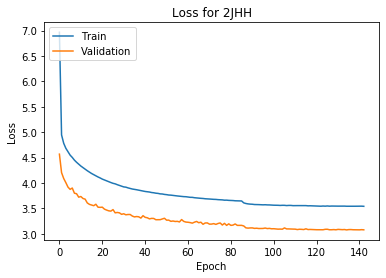

Training 1JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 39026 samples, validate on 4337 samples
Epoch 1/300
39026/39026 [==============================] - 4s 108us/step - loss: 50.3773 - dense_13_loss: 46.2010 - dense_7_loss: 0.7015 - dense_8_loss: 2.5748 - dense_9_loss: 0.9000 - val_loss: 46.1460 - val_dense_13_loss: 42.4992 - val_dense_7_loss: 0.5114 - val_dense_8_loss: 2.4268 - val_dense_9_loss: 0.7086
Epoch 2/300
39026/39026 [==============================] - 2s 40us/step - loss: 46.4410 - dense_13_loss: 42.8993 - dense_7_loss: 0.5026 - dense_8_loss: 2.2817 - dense_9_loss: 0.7573 - val_loss: 44.3953 - val_dense_13_loss: 41.1998 - val_dense_7_loss: 0.4000 - val_dense_8_loss: 2.1140 - val_dense_9_loss: 0.6816
Epoch 3/300
39026/39026 [==============================] - 2s 38us/step - loss: 43.1515 - dense_13_loss: 39.7947 - dense_7_loss: 0.4565 - dense_8_loss: 2.1734 - dense_9_loss: 0.7269 - val_loss: 41.0486 - val_dense_13_loss: 37.9534 - val_dense_7_

39026/39026 [==============================] - 2s 40us/step - loss: 6.4820 - dense_13_loss: 3.6922 - dense_7_loss: 0.3383 - dense_8_loss: 1.7797 - dense_9_loss: 0.6718 - val_loss: 4.1308 - val_dense_13_loss: 1.5544 - val_dense_7_loss: 0.2832 - val_dense_8_loss: 1.6250 - val_dense_9_loss: 0.6683
Epoch 28/300
39026/39026 [==============================] - 2s 39us/step - loss: 6.4307 - dense_13_loss: 3.6416 - dense_7_loss: 0.3367 - dense_8_loss: 1.7805 - dense_9_loss: 0.6719 - val_loss: 4.1654 - val_dense_13_loss: 1.5975 - val_dense_7_loss: 0.2851 - val_dense_8_loss: 1.6141 - val_dense_9_loss: 0.6687
Epoch 29/300
39026/39026 [==============================] - 1s 38us/step - loss: 6.4042 - dense_13_loss: 3.6281 - dense_7_loss: 0.3364 - dense_8_loss: 1.7680 - dense_9_loss: 0.6717 - val_loss: 4.0866 - val_dense_13_loss: 1.5217 - val_dense_7_loss: 0.2825 - val_dense_8_loss: 1.6134 - val_dense_9_loss: 0.6690
Epoch 30/300
39026/39026 [==============================] - 2s 39us/step - loss: 6.356

39026/39026 [==============================] - 2s 39us/step - loss: 5.9817 - dense_13_loss: 3.3391 - dense_7_loss: 0.3121 - dense_8_loss: 1.6589 - dense_9_loss: 0.6715 - val_loss: 3.8830 - val_dense_13_loss: 1.4636 - val_dense_7_loss: 0.2561 - val_dense_8_loss: 1.4951 - val_dense_9_loss: 0.6683
Epoch 54/300
39026/39026 [==============================] - 2s 39us/step - loss: 5.9850 - dense_13_loss: 3.3425 - dense_7_loss: 0.3116 - dense_8_loss: 1.6595 - dense_9_loss: 0.6713 - val_loss: 3.8769 - val_dense_13_loss: 1.4578 - val_dense_7_loss: 0.2529 - val_dense_8_loss: 1.4974 - val_dense_9_loss: 0.6687
Epoch 55/300
39026/39026 [==============================] - 2s 39us/step - loss: 5.9747 - dense_13_loss: 3.3399 - dense_7_loss: 0.3116 - dense_8_loss: 1.6518 - dense_9_loss: 0.6715 - val_loss: 3.8064 - val_dense_13_loss: 1.3960 - val_dense_7_loss: 0.2533 - val_dense_8_loss: 1.4890 - val_dense_9_loss: 0.6681
Epoch 56/300
39026/39026 [==============================] - 2s 39us/step - loss: 5.944

39026/39026 [==============================] - 2s 40us/step - loss: 5.7505 - dense_13_loss: 3.1906 - dense_7_loss: 0.2961 - dense_8_loss: 1.5928 - dense_9_loss: 0.6711 - val_loss: 3.6049 - val_dense_13_loss: 1.2645 - val_dense_7_loss: 0.2401 - val_dense_8_loss: 1.4326 - val_dense_9_loss: 0.6676
Epoch 80/300
39026/39026 [==============================] - 2s 39us/step - loss: 5.7212 - dense_13_loss: 3.1607 - dense_7_loss: 0.2976 - dense_8_loss: 1.5920 - dense_9_loss: 0.6709 - val_loss: 3.7224 - val_dense_13_loss: 1.3850 - val_dense_7_loss: 0.2420 - val_dense_8_loss: 1.4278 - val_dense_9_loss: 0.6676
Epoch 81/300
39026/39026 [==============================] - 1s 38us/step - loss: 5.7227 - dense_13_loss: 3.1632 - dense_7_loss: 0.2987 - dense_8_loss: 1.5899 - dense_9_loss: 0.6709 - val_loss: 3.6406 - val_dense_13_loss: 1.3041 - val_dense_7_loss: 0.2442 - val_dense_8_loss: 1.4247 - val_dense_9_loss: 0.6676
Epoch 82/300
39026/39026 [==============================] - 2s 40us/step - loss: 5.711

39026/39026 [==============================] - 2s 39us/step - loss: 5.4214 - dense_13_loss: 2.9482 - dense_7_loss: 0.2803 - dense_8_loss: 1.5233 - dense_9_loss: 0.6695 - val_loss: 3.4158 - val_dense_13_loss: 1.1656 - val_dense_7_loss: 0.2238 - val_dense_8_loss: 1.3599 - val_dense_9_loss: 0.6666
Epoch 106/300
39026/39026 [==============================] - 1s 36us/step - loss: 5.4328 - dense_13_loss: 2.9598 - dense_7_loss: 0.2805 - dense_8_loss: 1.5230 - dense_9_loss: 0.6695 - val_loss: 3.3989 - val_dense_13_loss: 1.1511 - val_dense_7_loss: 0.2226 - val_dense_8_loss: 1.3585 - val_dense_9_loss: 0.6666
Epoch 107/300
39026/39026 [==============================] - 2s 40us/step - loss: 5.4386 - dense_13_loss: 2.9677 - dense_7_loss: 0.2809 - dense_8_loss: 1.5205 - dense_9_loss: 0.6695 - val_loss: 3.3947 - val_dense_13_loss: 1.1489 - val_dense_7_loss: 0.2232 - val_dense_8_loss: 1.3561 - val_dense_9_loss: 0.6666
Epoch 108/300
39026/39026 [==============================] - 2s 39us/step - loss: 5.

39026/39026 [==============================] - 2s 39us/step - loss: 5.3654 - dense_13_loss: 2.9165 - dense_7_loss: 0.2785 - dense_8_loss: 1.5011 - dense_9_loss: 0.6693 - val_loss: 3.3540 - val_dense_13_loss: 1.1256 - val_dense_7_loss: 0.2203 - val_dense_8_loss: 1.3415 - val_dense_9_loss: 0.6666
Epoch 132/300
39026/39026 [==============================] - 2s 39us/step - loss: 5.3825 - dense_13_loss: 2.9342 - dense_7_loss: 0.2776 - dense_8_loss: 1.5014 - dense_9_loss: 0.6694 - val_loss: 3.3502 - val_dense_13_loss: 1.1230 - val_dense_7_loss: 0.2195 - val_dense_8_loss: 1.3411 - val_dense_9_loss: 0.6665
Epoch 133/300
39026/39026 [==============================] - 1s 38us/step - loss: 5.3722 - dense_13_loss: 2.9246 - dense_7_loss: 0.2764 - dense_8_loss: 1.5018 - dense_9_loss: 0.6694 - val_loss: 3.3633 - val_dense_13_loss: 1.1329 - val_dense_7_loss: 0.2203 - val_dense_8_loss: 1.3435 - val_dense_9_loss: 0.6665
Epoch 134/300
39026/39026 [==============================] - 2s 38us/step - loss: 5.

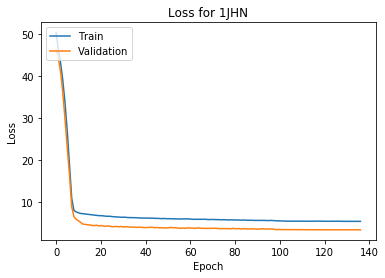

Training 2JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 107327 samples, validate on 11926 samples
Epoch 1/300
107327/107327 [==============================] - 7s 65us/step - loss: 5.4753 - dense_13_loss: 1.6675 - dense_7_loss: 0.5615 - dense_8_loss: 2.4288 - dense_9_loss: 0.8175 - val_loss: 4.2383 - val_dense_13_loss: 0.9485 - val_dense_7_loss: 0.4095 - val_dense_8_loss: 2.1581 - val_dense_9_loss: 0.7222
Epoch 2/300
107327/107327 [==============================] - 4s 38us/step - loss: 4.3638 - dense_13_loss: 1.0484 - dense_7_loss: 0.4151 - dense_8_loss: 2.1704 - dense_9_loss: 0.7300 - val_loss: 3.7813 - val_dense_13_loss: 0.7404 - val_dense_7_loss: 0.3122 - val_dense_8_loss: 2.0151 - val_dense_9_loss: 0.7136
Epoch 3/300
107327/107327 [==============================] - 4s 38us/step - loss: 4.1021 - dense_13_loss: 0.9323 - dense_7_loss: 0.3744 - dense_8_loss: 2.0819 - dense_9_loss: 0.7135 - val_loss: 3.6477 - val_dense_13_loss: 0.6825 - val_dense_7_loss:

Epoch 27/300
107327/107327 [==============================] - 4s 38us/step - loss: 3.2589 - dense_13_loss: 0.5588 - dense_7_loss: 0.2796 - dense_8_loss: 1.7105 - dense_9_loss: 0.7100 - val_loss: 2.8538 - val_dense_13_loss: 0.3785 - val_dense_7_loss: 0.2090 - val_dense_8_loss: 1.5540 - val_dense_9_loss: 0.7123
Epoch 28/300
107327/107327 [==============================] - 4s 39us/step - loss: 3.2487 - dense_13_loss: 0.5562 - dense_7_loss: 0.2781 - dense_8_loss: 1.7044 - dense_9_loss: 0.7100 - val_loss: 2.8461 - val_dense_13_loss: 0.3745 - val_dense_7_loss: 0.2102 - val_dense_8_loss: 1.5491 - val_dense_9_loss: 0.7123
Epoch 29/300
107327/107327 [==============================] - 4s 38us/step - loss: 3.2386 - dense_13_loss: 0.5520 - dense_7_loss: 0.2778 - dense_8_loss: 1.6989 - dense_9_loss: 0.7100 - val_loss: 2.8397 - val_dense_13_loss: 0.3715 - val_dense_7_loss: 0.2136 - val_dense_8_loss: 1.5422 - val_dense_9_loss: 0.7124
Epoch 30/300
107327/107327 [==============================] - 4s 38

107327/107327 [==============================] - 4s 40us/step - loss: 3.0582 - dense_13_loss: 0.4888 - dense_7_loss: 0.2574 - dense_8_loss: 1.6023 - dense_9_loss: 0.7096 - val_loss: 2.6701 - val_dense_13_loss: 0.3344 - val_dense_7_loss: 0.1928 - val_dense_8_loss: 1.4308 - val_dense_9_loss: 0.7121
Epoch 54/300
107327/107327 [==============================] - 4s 39us/step - loss: 3.0615 - dense_13_loss: 0.4895 - dense_7_loss: 0.2589 - dense_8_loss: 1.6035 - dense_9_loss: 0.7096 - val_loss: 2.6654 - val_dense_13_loss: 0.3273 - val_dense_7_loss: 0.1919 - val_dense_8_loss: 1.4339 - val_dense_9_loss: 0.7123
Epoch 55/300
107327/107327 [==============================] - 4s 38us/step - loss: 3.0550 - dense_13_loss: 0.4888 - dense_7_loss: 0.2575 - dense_8_loss: 1.5993 - dense_9_loss: 0.7095 - val_loss: 2.6550 - val_dense_13_loss: 0.3260 - val_dense_7_loss: 0.1875 - val_dense_8_loss: 1.4294 - val_dense_9_loss: 0.7121
Epoch 56/300
107327/107327 [==============================] - 4s 39us/step - los

107327/107327 [==============================] - 4s 38us/step - loss: 2.9666 - dense_13_loss: 0.4588 - dense_7_loss: 0.2483 - dense_8_loss: 1.5501 - dense_9_loss: 0.7094 - val_loss: 2.5790 - val_dense_13_loss: 0.3107 - val_dense_7_loss: 0.1826 - val_dense_8_loss: 1.3739 - val_dense_9_loss: 0.7119
Epoch 80/300
107327/107327 [==============================] - 4s 39us/step - loss: 2.9674 - dense_13_loss: 0.4603 - dense_7_loss: 0.2484 - dense_8_loss: 1.5493 - dense_9_loss: 0.7094 - val_loss: 2.5650 - val_dense_13_loss: 0.2998 - val_dense_7_loss: 0.1804 - val_dense_8_loss: 1.3730 - val_dense_9_loss: 0.7118
Epoch 81/300
107327/107327 [==============================] - 4s 39us/step - loss: 2.9555 - dense_13_loss: 0.4527 - dense_7_loss: 0.2476 - dense_8_loss: 1.5458 - dense_9_loss: 0.7094 - val_loss: 2.5678 - val_dense_13_loss: 0.3031 - val_dense_7_loss: 0.1829 - val_dense_8_loss: 1.3700 - val_dense_9_loss: 0.7118
Epoch 82/300
107327/107327 [==============================] - 4s 38us/step - los

107327/107327 [==============================] - 4s 38us/step - loss: 2.9003 - dense_13_loss: 0.4369 - dense_7_loss: 0.2417 - dense_8_loss: 1.5124 - dense_9_loss: 0.7093 - val_loss: 2.5084 - val_dense_13_loss: 0.2854 - val_dense_7_loss: 0.1734 - val_dense_8_loss: 1.3379 - val_dense_9_loss: 0.7117
Epoch 106/300
107327/107327 [==============================] - 4s 39us/step - loss: 2.9058 - dense_13_loss: 0.4393 - dense_7_loss: 0.2422 - dense_8_loss: 1.5149 - dense_9_loss: 0.7093 - val_loss: 2.5299 - val_dense_13_loss: 0.3122 - val_dense_7_loss: 0.1717 - val_dense_8_loss: 1.3341 - val_dense_9_loss: 0.7119
Epoch 107/300
107327/107327 [==============================] - 4s 39us/step - loss: 2.8981 - dense_13_loss: 0.4370 - dense_7_loss: 0.2411 - dense_8_loss: 1.5108 - dense_9_loss: 0.7093 - val_loss: 2.5097 - val_dense_13_loss: 0.2901 - val_dense_7_loss: 0.1724 - val_dense_8_loss: 1.3354 - val_dense_9_loss: 0.7117
Epoch 108/300
107327/107327 [==============================] - 4s 40us/step - 

107327/107327 [==============================] - 4s 39us/step - loss: 2.8622 - dense_13_loss: 0.4259 - dense_7_loss: 0.2384 - dense_8_loss: 1.4887 - dense_9_loss: 0.7092 - val_loss: 2.4675 - val_dense_13_loss: 0.2831 - val_dense_7_loss: 0.1665 - val_dense_8_loss: 1.3063 - val_dense_9_loss: 0.7116
Epoch 132/300
107327/107327 [==============================] - 4s 38us/step - loss: 2.8619 - dense_13_loss: 0.4258 - dense_7_loss: 0.2375 - dense_8_loss: 1.4893 - dense_9_loss: 0.7092 - val_loss: 2.4601 - val_dense_13_loss: 0.2777 - val_dense_7_loss: 0.1649 - val_dense_8_loss: 1.3058 - val_dense_9_loss: 0.7117
Epoch 133/300
107327/107327 [==============================] - 4s 39us/step - loss: 2.8581 - dense_13_loss: 0.4254 - dense_7_loss: 0.2381 - dense_8_loss: 1.4854 - dense_9_loss: 0.7092 - val_loss: 2.4719 - val_dense_13_loss: 0.2913 - val_dense_7_loss: 0.1663 - val_dense_8_loss: 1.3024 - val_dense_9_loss: 0.7119
Epoch 134/300
107327/107327 [==============================] - 4s 39us/step - 

107327/107327 [==============================] - 4s 39us/step - loss: 2.8287 - dense_13_loss: 0.4144 - dense_7_loss: 0.2352 - dense_8_loss: 1.4700 - dense_9_loss: 0.7091 - val_loss: 2.4418 - val_dense_13_loss: 0.2736 - val_dense_7_loss: 0.1686 - val_dense_8_loss: 1.2878 - val_dense_9_loss: 0.7117
Epoch 158/300
107327/107327 [==============================] - 4s 39us/step - loss: 2.8269 - dense_13_loss: 0.4147 - dense_7_loss: 0.2344 - dense_8_loss: 1.4688 - dense_9_loss: 0.7091 - val_loss: 2.4445 - val_dense_13_loss: 0.2785 - val_dense_7_loss: 0.1656 - val_dense_8_loss: 1.2887 - val_dense_9_loss: 0.7116
Epoch 159/300
107327/107327 [==============================] - 4s 38us/step - loss: 2.8272 - dense_13_loss: 0.4139 - dense_7_loss: 0.2347 - dense_8_loss: 1.4695 - dense_9_loss: 0.7091 - val_loss: 2.4324 - val_dense_13_loss: 0.2699 - val_dense_7_loss: 0.1663 - val_dense_8_loss: 1.2845 - val_dense_9_loss: 0.7116
Epoch 160/300
107327/107327 [==============================] - 4s 39us/step - 

107327/107327 [==============================] - 4s 39us/step - loss: 2.7997 - dense_13_loss: 0.4049 - dense_7_loss: 0.2325 - dense_8_loss: 1.4532 - dense_9_loss: 0.7091 - val_loss: 2.4317 - val_dense_13_loss: 0.2837 - val_dense_7_loss: 0.1666 - val_dense_8_loss: 1.2697 - val_dense_9_loss: 0.7117
Epoch 184/300
107327/107327 [==============================] - 4s 39us/step - loss: 2.7971 - dense_13_loss: 0.4054 - dense_7_loss: 0.2320 - dense_8_loss: 1.4506 - dense_9_loss: 0.7091 - val_loss: 2.4162 - val_dense_13_loss: 0.2759 - val_dense_7_loss: 0.1608 - val_dense_8_loss: 1.2678 - val_dense_9_loss: 0.7117
Epoch 185/300
107327/107327 [==============================] - 4s 39us/step - loss: 2.7994 - dense_13_loss: 0.4058 - dense_7_loss: 0.2327 - dense_8_loss: 1.4518 - dense_9_loss: 0.7091 - val_loss: 2.4119 - val_dense_13_loss: 0.2657 - val_dense_7_loss: 0.1618 - val_dense_8_loss: 1.2728 - val_dense_9_loss: 0.7116
Epoch 186/300
107327/107327 [==============================] - 4s 40us/step - 

107327/107327 [==============================] - 4s 38us/step - loss: 2.7321 - dense_13_loss: 0.3836 - dense_7_loss: 0.2251 - dense_8_loss: 1.4152 - dense_9_loss: 0.7081 - val_loss: 2.3624 - val_dense_13_loss: 0.2575 - val_dense_7_loss: 0.1561 - val_dense_8_loss: 1.2376 - val_dense_9_loss: 0.7111
Epoch 210/300
107327/107327 [==============================] - 4s 39us/step - loss: 2.7274 - dense_13_loss: 0.3831 - dense_7_loss: 0.2242 - dense_8_loss: 1.4119 - dense_9_loss: 0.7082 - val_loss: 2.3610 - val_dense_13_loss: 0.2558 - val_dense_7_loss: 0.1558 - val_dense_8_loss: 1.2382 - val_dense_9_loss: 0.7111
Epoch 211/300
107327/107327 [==============================] - 4s 38us/step - loss: 2.7292 - dense_13_loss: 0.3833 - dense_7_loss: 0.2248 - dense_8_loss: 1.4129 - dense_9_loss: 0.7082 - val_loss: 2.3597 - val_dense_13_loss: 0.2565 - val_dense_7_loss: 0.1551 - val_dense_8_loss: 1.2369 - val_dense_9_loss: 0.7111
Epoch 212/300
107327/107327 [==============================] - 4s 39us/step - 

107327/107327 [==============================] - 4s 39us/step - loss: 2.7220 - dense_13_loss: 0.3807 - dense_7_loss: 0.2245 - dense_8_loss: 1.4086 - dense_9_loss: 0.7082 - val_loss: 2.3523 - val_dense_13_loss: 0.2542 - val_dense_7_loss: 0.1558 - val_dense_8_loss: 1.2311 - val_dense_9_loss: 0.7112
Epoch 236/300
107327/107327 [==============================] - 4s 38us/step - loss: 2.7151 - dense_13_loss: 0.3779 - dense_7_loss: 0.2241 - dense_8_loss: 1.4050 - dense_9_loss: 0.7082 - val_loss: 2.3509 - val_dense_13_loss: 0.2533 - val_dense_7_loss: 0.1551 - val_dense_8_loss: 1.2314 - val_dense_9_loss: 0.7112
Epoch 237/300
107327/107327 [==============================] - 4s 40us/step - loss: 2.7181 - dense_13_loss: 0.3787 - dense_7_loss: 0.2249 - dense_8_loss: 1.4063 - dense_9_loss: 0.7082 - val_loss: 2.3549 - val_dense_13_loss: 0.2551 - val_dense_7_loss: 0.1554 - val_dense_8_loss: 1.2332 - val_dense_9_loss: 0.7112
Epoch 238/300
107327/107327 [==============================] - 4s 39us/step - 

107327/107327 [==============================] - 4s 39us/step - loss: 2.7079 - dense_13_loss: 0.3769 - dense_7_loss: 0.2231 - dense_8_loss: 1.3997 - dense_9_loss: 0.7081 - val_loss: 2.3445 - val_dense_13_loss: 0.2515 - val_dense_7_loss: 0.1544 - val_dense_8_loss: 1.2275 - val_dense_9_loss: 0.7111
Epoch 262/300
107327/107327 [==============================] - 4s 39us/step - loss: 2.7067 - dense_13_loss: 0.3767 - dense_7_loss: 0.2226 - dense_8_loss: 1.3993 - dense_9_loss: 0.7081 - val_loss: 2.3434 - val_dense_13_loss: 0.2508 - val_dense_7_loss: 0.1540 - val_dense_8_loss: 1.2274 - val_dense_9_loss: 0.7111
Epoch 263/300
107327/107327 [==============================] - 4s 39us/step - loss: 2.7071 - dense_13_loss: 0.3767 - dense_7_loss: 0.2224 - dense_8_loss: 1.3999 - dense_9_loss: 0.7081 - val_loss: 2.3459 - val_dense_13_loss: 0.2515 - val_dense_7_loss: 0.1548 - val_dense_8_loss: 1.2285 - val_dense_9_loss: 0.7111
Epoch 264/300
107327/107327 [==============================] - 4s 39us/step - 

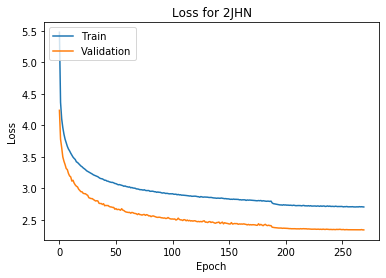

Training 2JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 1026606 samples, validate on 114068 samples
Epoch 1/300
1026606/1026606 [==============================] - 43s 42us/step - loss: 5.2014 - dense_13_loss: 1.8101 - dense_7_loss: 0.3728 - dense_8_loss: 2.3095 - dense_9_loss: 0.7091 - val_loss: 4.4546 - val_dense_13_loss: 1.4269 - val_dense_7_loss: 0.2727 - val_dense_8_loss: 2.0600 - val_dense_9_loss: 0.6951
Epoch 2/300
1026606/1026606 [==============================] - 40s 39us/step - loss: 4.5968 - dense_13_loss: 1.4596 - dense_7_loss: 0.3155 - dense_8_loss: 2.1272 - dense_9_loss: 0.6945 - val_loss: 4.0456 - val_dense_13_loss: 1.1527 - val_dense_7_loss: 0.2489 - val_dense_8_loss: 1.9494 - val_dense_9_loss: 0.6947
Epoch 3/300
1026606/1026606 [==============================] - 40s 39us/step - loss: 4.3663 - dense_13_loss: 1.3187 - dense_7_loss: 0.2976 - dense_8_loss: 2.0557 - dense_9_loss: 0.6943 - val_loss: 3.9325 - val_dense_13_loss: 1.1142 - val_de

Epoch 27/300
1026606/1026606 [==============================] - 40s 39us/step - loss: 3.7331 - dense_13_loss: 0.9879 - dense_7_loss: 0.2466 - dense_8_loss: 1.8050 - dense_9_loss: 0.6936 - val_loss: 3.2810 - val_dense_13_loss: 0.7982 - val_dense_7_loss: 0.1849 - val_dense_8_loss: 1.6035 - val_dense_9_loss: 0.6943
Epoch 28/300
1026606/1026606 [==============================] - 40s 39us/step - loss: 3.7236 - dense_13_loss: 0.9817 - dense_7_loss: 0.2463 - dense_8_loss: 1.8020 - dense_9_loss: 0.6936 - val_loss: 3.2598 - val_dense_13_loss: 0.7889 - val_dense_7_loss: 0.1807 - val_dense_8_loss: 1.5959 - val_dense_9_loss: 0.6942
Epoch 29/300
1026606/1026606 [==============================] - 40s 39us/step - loss: 3.7188 - dense_13_loss: 0.9803 - dense_7_loss: 0.2455 - dense_8_loss: 1.7994 - dense_9_loss: 0.6936 - val_loss: 3.2525 - val_dense_13_loss: 0.7844 - val_dense_7_loss: 0.1791 - val_dense_8_loss: 1.5946 - val_dense_9_loss: 0.6943
Epoch 30/300
1026606/1026606 [============================

1026606/1026606 [==============================] - 40s 39us/step - loss: 3.6170 - dense_13_loss: 0.9292 - dense_7_loss: 0.2384 - dense_8_loss: 1.7560 - dense_9_loss: 0.6935 - val_loss: 3.1254 - val_dense_13_loss: 0.7265 - val_dense_7_loss: 0.1708 - val_dense_8_loss: 1.5341 - val_dense_9_loss: 0.6941
Epoch 54/300
1026606/1026606 [==============================] - 40s 39us/step - loss: 3.6144 - dense_13_loss: 0.9282 - dense_7_loss: 0.2380 - dense_8_loss: 1.7547 - dense_9_loss: 0.6935 - val_loss: 3.1274 - val_dense_13_loss: 0.7275 - val_dense_7_loss: 0.1716 - val_dense_8_loss: 1.5341 - val_dense_9_loss: 0.6942
Epoch 55/300
1026606/1026606 [==============================] - 40s 39us/step - loss: 3.6128 - dense_13_loss: 0.9273 - dense_7_loss: 0.2382 - dense_8_loss: 1.7538 - dense_9_loss: 0.6935 - val_loss: 3.1112 - val_dense_13_loss: 0.7172 - val_dense_7_loss: 0.1717 - val_dense_8_loss: 1.5282 - val_dense_9_loss: 0.6941
Epoch 56/300
1026606/1026606 [==============================] - 40s 39u

1026606/1026606 [==============================] - 40s 39us/step - loss: 3.5583 - dense_13_loss: 0.8999 - dense_7_loss: 0.2343 - dense_8_loss: 1.7307 - dense_9_loss: 0.6934 - val_loss: 3.0763 - val_dense_13_loss: 0.7063 - val_dense_7_loss: 0.1684 - val_dense_8_loss: 1.5073 - val_dense_9_loss: 0.6943
Epoch 80/300
1026606/1026606 [==============================] - 40s 39us/step - loss: 3.5558 - dense_13_loss: 0.8988 - dense_7_loss: 0.2342 - dense_8_loss: 1.7294 - dense_9_loss: 0.6934 - val_loss: 3.0598 - val_dense_13_loss: 0.6971 - val_dense_7_loss: 0.1680 - val_dense_8_loss: 1.5005 - val_dense_9_loss: 0.6942
Epoch 81/300
1026606/1026606 [==============================] - 40s 39us/step - loss: 3.5554 - dense_13_loss: 0.8990 - dense_7_loss: 0.2342 - dense_8_loss: 1.7289 - dense_9_loss: 0.6934 - val_loss: 3.0481 - val_dense_13_loss: 0.6900 - val_dense_7_loss: 0.1665 - val_dense_8_loss: 1.4975 - val_dense_9_loss: 0.6941
Epoch 82/300
1026606/1026606 [==============================] - 40s 39u

1026606/1026606 [==============================] - 40s 39us/step - loss: 3.5225 - dense_13_loss: 0.8834 - dense_7_loss: 0.2322 - dense_8_loss: 1.7136 - dense_9_loss: 0.6933 - val_loss: 3.0162 - val_dense_13_loss: 0.6764 - val_dense_7_loss: 0.1660 - val_dense_8_loss: 1.4798 - val_dense_9_loss: 0.6941
Epoch 106/300
1026606/1026606 [==============================] - 40s 39us/step - loss: 3.5205 - dense_13_loss: 0.8825 - dense_7_loss: 0.2319 - dense_8_loss: 1.7129 - dense_9_loss: 0.6933 - val_loss: 3.0159 - val_dense_13_loss: 0.6770 - val_dense_7_loss: 0.1649 - val_dense_8_loss: 1.4799 - val_dense_9_loss: 0.6941
Epoch 107/300
1026606/1026606 [==============================] - 40s 39us/step - loss: 3.5176 - dense_13_loss: 0.8808 - dense_7_loss: 0.2317 - dense_8_loss: 1.7118 - dense_9_loss: 0.6933 - val_loss: 3.0104 - val_dense_13_loss: 0.6742 - val_dense_7_loss: 0.1642 - val_dense_8_loss: 1.4779 - val_dense_9_loss: 0.6942
Epoch 108/300
1026606/1026606 [==============================] - 43s 

Epoch 131/300
1026606/1026606 [==============================] - 55s 53us/step - loss: 3.4464 - dense_13_loss: 0.8433 - dense_7_loss: 0.2266 - dense_8_loss: 1.6838 - dense_9_loss: 0.6927 - val_loss: 2.9613 - val_dense_13_loss: 0.6541 - val_dense_7_loss: 0.1616 - val_dense_8_loss: 1.4519 - val_dense_9_loss: 0.6937
Epoch 132/300
1026606/1026606 [==============================] - 55s 53us/step - loss: 3.4449 - dense_13_loss: 0.8426 - dense_7_loss: 0.2262 - dense_8_loss: 1.6833 - dense_9_loss: 0.6927 - val_loss: 2.9484 - val_dense_13_loss: 0.6463 - val_dense_7_loss: 0.1605 - val_dense_8_loss: 1.4479 - val_dense_9_loss: 0.6937
Epoch 133/300
1026606/1026606 [==============================] - 54s 52us/step - loss: 3.4421 - dense_13_loss: 0.8418 - dense_7_loss: 0.2261 - dense_8_loss: 1.6815 - dense_9_loss: 0.6927 - val_loss: 2.9435 - val_dense_13_loss: 0.6444 - val_dense_7_loss: 0.1593 - val_dense_8_loss: 1.4461 - val_dense_9_loss: 0.6937
Epoch 134/300
1026606/1026606 [========================

1026606/1026606 [==============================] - 50s 48us/step - loss: 3.4304 - dense_13_loss: 0.8359 - dense_7_loss: 0.2253 - dense_8_loss: 1.6765 - dense_9_loss: 0.6927 - val_loss: 2.9336 - val_dense_13_loss: 0.6413 - val_dense_7_loss: 0.1590 - val_dense_8_loss: 1.4396 - val_dense_9_loss: 0.6937
Epoch 158/300
1026606/1026606 [==============================] - 50s 49us/step - loss: 3.4305 - dense_13_loss: 0.8352 - dense_7_loss: 0.2253 - dense_8_loss: 1.6774 - dense_9_loss: 0.6927 - val_loss: 2.9321 - val_dense_13_loss: 0.6397 - val_dense_7_loss: 0.1589 - val_dense_8_loss: 1.4399 - val_dense_9_loss: 0.6937
Epoch 159/300
1026606/1026606 [==============================] - 66s 64us/step - loss: 3.4295 - dense_13_loss: 0.8361 - dense_7_loss: 0.2250 - dense_8_loss: 1.6756 - dense_9_loss: 0.6927 - val_loss: 2.9307 - val_dense_13_loss: 0.6389 - val_dense_7_loss: 0.1588 - val_dense_8_loss: 1.4393 - val_dense_9_loss: 0.6937
Epoch 160/300
1026606/1026606 [==============================] - 51s 

1026606/1026606 [==============================] - 49s 48us/step - loss: 3.4258 - dense_13_loss: 0.8339 - dense_7_loss: 0.2247 - dense_8_loss: 1.6746 - dense_9_loss: 0.6927 - val_loss: 2.9226 - val_dense_13_loss: 0.6359 - val_dense_7_loss: 0.1582 - val_dense_8_loss: 1.4348 - val_dense_9_loss: 0.6937

Epoch 00183: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 184/300
1026606/1026606 [==============================] - 50s 48us/step - loss: 3.4210 - dense_13_loss: 0.8311 - dense_7_loss: 0.2247 - dense_8_loss: 1.6725 - dense_9_loss: 0.6927 - val_loss: 2.9219 - val_dense_13_loss: 0.6348 - val_dense_7_loss: 0.1582 - val_dense_8_loss: 1.4353 - val_dense_9_loss: 0.6936
Restoring model weights from the end of the best epoch
Epoch 00184: early stopping


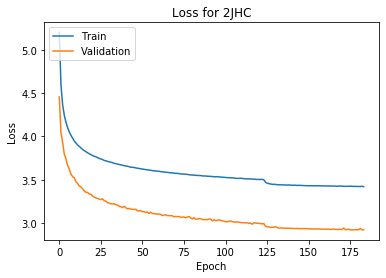

Training 3JHH out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 531549 samples, validate on 59062 samples
Epoch 1/300
531549/531549 [==============================] - 30s 56us/step - loss: 5.5735 - dense_13_loss: 1.5596 - dense_7_loss: 0.4407 - dense_8_loss: 2.7919 - dense_9_loss: 0.7814 - val_loss: 4.5822 - val_dense_13_loss: 0.9163 - val_dense_7_loss: 0.3397 - val_dense_8_loss: 2.5746 - val_dense_9_loss: 0.7515
Epoch 2/300
531549/531549 [==============================] - 25s 48us/step - loss: 4.7742 - dense_13_loss: 1.0763 - dense_7_loss: 0.3422 - dense_8_loss: 2.6025 - dense_9_loss: 0.7532 - val_loss: 4.2099 - val_dense_13_loss: 0.7669 - val_dense_7_loss: 0.2644 - val_dense_8_loss: 2.4268 - val_dense_9_loss: 0.7519
Epoch 3/300
531549/531549 [==============================] - 26s 48us/step - loss: 4.5372 - dense_13_loss: 0.9615 - dense_7_loss: 0.3109 - dense_8_loss: 2.5117 - dense_9_loss: 0.7531 - val_loss: 4.0537 - val_dense_13_loss: 0.7083 - val_dense_7_lo

Epoch 27/300
531549/531549 [==============================] - 35s 65us/step - loss: 3.7964 - dense_13_loss: 0.6258 - dense_7_loss: 0.2472 - dense_8_loss: 2.1715 - dense_9_loss: 0.7520 - val_loss: 3.3323 - val_dense_13_loss: 0.4381 - val_dense_7_loss: 0.1864 - val_dense_8_loss: 1.9575 - val_dense_9_loss: 0.7503
Epoch 28/300
531549/531549 [==============================] - 25s 47us/step - loss: 3.7838 - dense_13_loss: 0.6201 - dense_7_loss: 0.2464 - dense_8_loss: 2.1653 - dense_9_loss: 0.7519 - val_loss: 3.3266 - val_dense_13_loss: 0.4385 - val_dense_7_loss: 0.1875 - val_dense_8_loss: 1.9503 - val_dense_9_loss: 0.7504
Epoch 29/300
531549/531549 [==============================] - 25s 47us/step - loss: 3.7801 - dense_13_loss: 0.6187 - dense_7_loss: 0.2460 - dense_8_loss: 2.1635 - dense_9_loss: 0.7519 - val_loss: 3.3336 - val_dense_13_loss: 0.4474 - val_dense_7_loss: 0.1877 - val_dense_8_loss: 1.9480 - val_dense_9_loss: 0.7505
Epoch 30/300
531549/531549 [==============================] - 25

531549/531549 [==============================] - 25s 48us/step - loss: 3.6664 - dense_13_loss: 0.5779 - dense_7_loss: 0.2379 - dense_8_loss: 2.0989 - dense_9_loss: 0.7518 - val_loss: 3.1910 - val_dense_13_loss: 0.4035 - val_dense_7_loss: 0.1794 - val_dense_8_loss: 1.8577 - val_dense_9_loss: 0.7504
Epoch 54/300
531549/531549 [==============================] - 26s 48us/step - loss: 3.6627 - dense_13_loss: 0.5763 - dense_7_loss: 0.2377 - dense_8_loss: 2.0969 - dense_9_loss: 0.7518 - val_loss: 3.1913 - val_dense_13_loss: 0.4020 - val_dense_7_loss: 0.1764 - val_dense_8_loss: 1.8627 - val_dense_9_loss: 0.7502
Epoch 55/300
531549/531549 [==============================] - 25s 48us/step - loss: 3.6572 - dense_13_loss: 0.5735 - dense_7_loss: 0.2379 - dense_8_loss: 2.0941 - dense_9_loss: 0.7518 - val_loss: 3.1835 - val_dense_13_loss: 0.4011 - val_dense_7_loss: 0.1787 - val_dense_8_loss: 1.8534 - val_dense_9_loss: 0.7503
Epoch 56/300
531549/531549 [==============================] - 26s 49us/step -

531549/531549 [==============================] - 26s 49us/step - loss: 3.6027 - dense_13_loss: 0.5550 - dense_7_loss: 0.2337 - dense_8_loss: 2.0624 - dense_9_loss: 0.7517 - val_loss: 3.1275 - val_dense_13_loss: 0.3891 - val_dense_7_loss: 0.1725 - val_dense_8_loss: 1.8157 - val_dense_9_loss: 0.7502
Epoch 80/300
531549/531549 [==============================] - 26s 49us/step - loss: 3.5990 - dense_13_loss: 0.5535 - dense_7_loss: 0.2334 - dense_8_loss: 2.0605 - dense_9_loss: 0.7517 - val_loss: 3.1325 - val_dense_13_loss: 0.3947 - val_dense_7_loss: 0.1736 - val_dense_8_loss: 1.8141 - val_dense_9_loss: 0.7501
Epoch 81/300
531549/531549 [==============================] - 26s 49us/step - loss: 3.5991 - dense_13_loss: 0.5539 - dense_7_loss: 0.2337 - dense_8_loss: 2.0598 - dense_9_loss: 0.7517 - val_loss: 3.1180 - val_dense_13_loss: 0.3861 - val_dense_7_loss: 0.1733 - val_dense_8_loss: 1.8085 - val_dense_9_loss: 0.7501
Epoch 82/300
531549/531549 [==============================] - 27s 50us/step -

531549/531549 [==============================] - 26s 49us/step - loss: 3.5613 - dense_13_loss: 0.5417 - dense_7_loss: 0.2310 - dense_8_loss: 2.0370 - dense_9_loss: 0.7516 - val_loss: 3.0777 - val_dense_13_loss: 0.3777 - val_dense_7_loss: 0.1716 - val_dense_8_loss: 1.7782 - val_dense_9_loss: 0.7502
Epoch 106/300
531549/531549 [==============================] - 26s 49us/step - loss: 3.5565 - dense_13_loss: 0.5404 - dense_7_loss: 0.2308 - dense_8_loss: 2.0337 - dense_9_loss: 0.7516 - val_loss: 3.0714 - val_dense_13_loss: 0.3719 - val_dense_7_loss: 0.1690 - val_dense_8_loss: 1.7805 - val_dense_9_loss: 0.7500
Epoch 107/300
531549/531549 [==============================] - 26s 49us/step - loss: 3.5575 - dense_13_loss: 0.5401 - dense_7_loss: 0.2312 - dense_8_loss: 2.0346 - dense_9_loss: 0.7516 - val_loss: 3.0860 - val_dense_13_loss: 0.3829 - val_dense_7_loss: 0.1718 - val_dense_8_loss: 1.7812 - val_dense_9_loss: 0.7501
Epoch 108/300
531549/531549 [==============================] - 26s 49us/ste

Epoch 131/300
531549/531549 [==============================] - 27s 50us/step - loss: 3.4820 - dense_13_loss: 0.5132 - dense_7_loss: 0.2256 - dense_8_loss: 1.9923 - dense_9_loss: 0.7510 - val_loss: 3.0059 - val_dense_13_loss: 0.3537 - val_dense_7_loss: 0.1667 - val_dense_8_loss: 1.7359 - val_dense_9_loss: 0.7497
Epoch 132/300
531549/531549 [==============================] - 26s 50us/step - loss: 3.4801 - dense_13_loss: 0.5117 - dense_7_loss: 0.2251 - dense_8_loss: 1.9924 - dense_9_loss: 0.7510 - val_loss: 3.0059 - val_dense_13_loss: 0.3550 - val_dense_7_loss: 0.1665 - val_dense_8_loss: 1.7347 - val_dense_9_loss: 0.7497
Epoch 133/300
531549/531549 [==============================] - 26s 48us/step - loss: 3.4796 - dense_13_loss: 0.5120 - dense_7_loss: 0.2251 - dense_8_loss: 1.9915 - dense_9_loss: 0.7510 - val_loss: 2.9994 - val_dense_13_loss: 0.3500 - val_dense_7_loss: 0.1664 - val_dense_8_loss: 1.7334 - val_dense_9_loss: 0.7497
Epoch 134/300
531549/531549 [==============================] 

531549/531549 [==============================] - 26s 49us/step - loss: 3.4646 - dense_13_loss: 0.5065 - dense_7_loss: 0.2243 - dense_8_loss: 1.9828 - dense_9_loss: 0.7510 - val_loss: 2.9891 - val_dense_13_loss: 0.3489 - val_dense_7_loss: 0.1661 - val_dense_8_loss: 1.7244 - val_dense_9_loss: 0.7497
Epoch 158/300
531549/531549 [==============================] - 45s 85us/step - loss: 3.4640 - dense_13_loss: 0.5062 - dense_7_loss: 0.2245 - dense_8_loss: 1.9824 - dense_9_loss: 0.7509 - val_loss: 2.9854 - val_dense_13_loss: 0.3489 - val_dense_7_loss: 0.1645 - val_dense_8_loss: 1.7223 - val_dense_9_loss: 0.7497

Epoch 00158: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 159/300
531549/531549 [==============================] - 30s 56us/step - loss: 3.4633 - dense_13_loss: 0.5059 - dense_7_loss: 0.2241 - dense_8_loss: 1.9824 - dense_9_loss: 0.7509 - val_loss: 2.9867 - val_dense_13_loss: 0.3475 - val_dense_7_loss: 0.1657 - val_dense_8_loss: 1.7238 - val_dense_9_loss: 

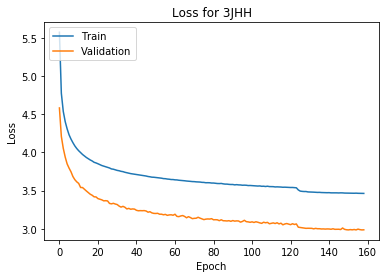

Training 3JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 1359341 samples, validate on 151038 samples
Epoch 1/300
1359341/1359341 [==============================] - 71s 52us/step - loss: 5.1309 - dense_13_loss: 1.5781 - dense_7_loss: 0.4201 - dense_8_loss: 2.4248 - dense_9_loss: 0.7080 - val_loss: 4.3884 - val_dense_13_loss: 1.2074 - val_dense_7_loss: 0.3055 - val_dense_8_loss: 2.1799 - val_dense_9_loss: 0.6956
Epoch 2/300
1359341/1359341 [==============================] - 67s 49us/step - loss: 4.5794 - dense_13_loss: 1.2857 - dense_7_loss: 0.3412 - dense_8_loss: 2.2563 - dense_9_loss: 0.6961 - val_loss: 4.0645 - val_dense_13_loss: 1.0183 - val_dense_7_loss: 0.2804 - val_dense_8_loss: 2.0706 - val_dense_9_loss: 0.6952
Epoch 3/300
1359341/1359341 [==============================] - 67s 49us/step - loss: 4.3701 - dense_13_loss: 1.1696 - dense_7_loss: 0.3244 - dense_8_loss: 2.1803 - dense_9_loss: 0.6958 - val_loss: 3.8985 - val_dense_13_loss: 0.9414 - val_de

Epoch 27/300
1359341/1359341 [==============================] - 65s 48us/step - loss: 3.8010 - dense_13_loss: 0.9008 - dense_7_loss: 0.2787 - dense_8_loss: 1.9265 - dense_9_loss: 0.6950 - val_loss: 3.3154 - val_dense_13_loss: 0.7184 - val_dense_7_loss: 0.2132 - val_dense_8_loss: 1.6892 - val_dense_9_loss: 0.6946
Epoch 28/300
1359341/1359341 [==============================] - 81s 59us/step - loss: 3.7958 - dense_13_loss: 0.8980 - dense_7_loss: 0.2783 - dense_8_loss: 1.9246 - dense_9_loss: 0.6950 - val_loss: 3.3047 - val_dense_13_loss: 0.7141 - val_dense_7_loss: 0.2128 - val_dense_8_loss: 1.6833 - val_dense_9_loss: 0.6945
Epoch 29/300
1359341/1359341 [==============================] - 66s 49us/step - loss: 3.7891 - dense_13_loss: 0.8952 - dense_7_loss: 0.2778 - dense_8_loss: 1.9210 - dense_9_loss: 0.6950 - val_loss: 3.3040 - val_dense_13_loss: 0.7114 - val_dense_7_loss: 0.2161 - val_dense_8_loss: 1.6820 - val_dense_9_loss: 0.6946
Epoch 30/300
1359341/1359341 [============================

1359341/1359341 [==============================] - 76s 56us/step - loss: 3.6980 - dense_13_loss: 0.8559 - dense_7_loss: 0.2698 - dense_8_loss: 1.8774 - dense_9_loss: 0.6949 - val_loss: 3.1893 - val_dense_13_loss: 0.6674 - val_dense_7_loss: 0.2017 - val_dense_8_loss: 1.6258 - val_dense_9_loss: 0.6945
Epoch 54/300
1359341/1359341 [==============================] - 77s 57us/step - loss: 3.6943 - dense_13_loss: 0.8546 - dense_7_loss: 0.2692 - dense_8_loss: 1.8756 - dense_9_loss: 0.6949 - val_loss: 3.1858 - val_dense_13_loss: 0.6686 - val_dense_7_loss: 0.2013 - val_dense_8_loss: 1.6215 - val_dense_9_loss: 0.6944
Epoch 55/300
1359341/1359341 [==============================] - 76s 56us/step - loss: 3.6920 - dense_13_loss: 0.8538 - dense_7_loss: 0.2690 - dense_8_loss: 1.8743 - dense_9_loss: 0.6949 - val_loss: 3.1817 - val_dense_13_loss: 0.6649 - val_dense_7_loss: 0.2002 - val_dense_8_loss: 1.6221 - val_dense_9_loss: 0.6944
Epoch 56/300
1359341/1359341 [==============================] - 76s 56u

1359341/1359341 [==============================] - 76s 56us/step - loss: 3.6403 - dense_13_loss: 0.8327 - dense_7_loss: 0.2644 - dense_8_loss: 1.8484 - dense_9_loss: 0.6949 - val_loss: 3.1480 - val_dense_13_loss: 0.6532 - val_dense_7_loss: 0.2008 - val_dense_8_loss: 1.5997 - val_dense_9_loss: 0.6944
Epoch 80/300
1359341/1359341 [==============================] - 76s 56us/step - loss: 3.6358 - dense_13_loss: 0.8302 - dense_7_loss: 0.2640 - dense_8_loss: 1.8468 - dense_9_loss: 0.6949 - val_loss: 3.1630 - val_dense_13_loss: 0.6523 - val_dense_7_loss: 0.2009 - val_dense_8_loss: 1.6153 - val_dense_9_loss: 0.6945
Epoch 81/300
1359341/1359341 [==============================] - 77s 56us/step - loss: 3.6348 - dense_13_loss: 0.8300 - dense_7_loss: 0.2639 - dense_8_loss: 1.8460 - dense_9_loss: 0.6949 - val_loss: 3.1382 - val_dense_13_loss: 0.6444 - val_dense_7_loss: 0.1989 - val_dense_8_loss: 1.6003 - val_dense_9_loss: 0.6944
Epoch 82/300
1359341/1359341 [==============================] - 76s 56u

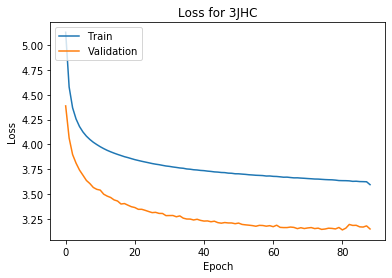

Training 3JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 149773 samples, validate on 16642 samples
Epoch 1/300
149773/149773 [==============================] - 14s 96us/step - loss: 4.7403 - dense_13_loss: 0.8232 - dense_7_loss: 0.5850 - dense_8_loss: 2.5366 - dense_9_loss: 0.7955 - val_loss: 3.9145 - val_dense_13_loss: 0.6504 - val_dense_7_loss: 0.3562 - val_dense_8_loss: 2.2021 - val_dense_9_loss: 0.7057
Epoch 2/300
149773/149773 [==============================] - 8s 54us/step - loss: 4.0321 - dense_13_loss: 0.6622 - dense_7_loss: 0.4015 - dense_8_loss: 2.2599 - dense_9_loss: 0.7084 - val_loss: 3.6361 - val_dense_13_loss: 0.5647 - val_dense_7_loss: 0.3077 - val_dense_8_loss: 2.0657 - val_dense_9_loss: 0.6979
Epoch 3/300
149773/149773 [==============================] - 9s 57us/step - loss: 3.8148 - dense_13_loss: 0.5912 - dense_7_loss: 0.3629 - dense_8_loss: 2.1641 - dense_9_loss: 0.6966 - val_loss: 3.4817 - val_dense_13_loss: 0.4988 - val_dense_7_loss

Epoch 27/300
149773/149773 [==============================] - 8s 56us/step - loss: 3.0591 - dense_13_loss: 0.3586 - dense_7_loss: 0.2752 - dense_8_loss: 1.7301 - dense_9_loss: 0.6951 - val_loss: 2.7225 - val_dense_13_loss: 0.2917 - val_dense_7_loss: 0.2083 - val_dense_8_loss: 1.5252 - val_dense_9_loss: 0.6974
Epoch 28/300
149773/149773 [==============================] - 8s 55us/step - loss: 3.0488 - dense_13_loss: 0.3565 - dense_7_loss: 0.2741 - dense_8_loss: 1.7230 - dense_9_loss: 0.6951 - val_loss: 2.6964 - val_dense_13_loss: 0.2808 - val_dense_7_loss: 0.2062 - val_dense_8_loss: 1.5118 - val_dense_9_loss: 0.6976
Epoch 29/300
149773/149773 [==============================] - 8s 56us/step - loss: 3.0367 - dense_13_loss: 0.3537 - dense_7_loss: 0.2722 - dense_8_loss: 1.7157 - dense_9_loss: 0.6951 - val_loss: 2.6941 - val_dense_13_loss: 0.2787 - val_dense_7_loss: 0.2088 - val_dense_8_loss: 1.5093 - val_dense_9_loss: 0.6973
Epoch 30/300
149773/149773 [==============================] - 8s 56

149773/149773 [==============================] - 8s 56us/step - loss: 2.8994 - dense_13_loss: 0.3197 - dense_7_loss: 0.2576 - dense_8_loss: 1.6274 - dense_9_loss: 0.6948 - val_loss: 2.5460 - val_dense_13_loss: 0.2515 - val_dense_7_loss: 0.1891 - val_dense_8_loss: 1.4083 - val_dense_9_loss: 0.6971
Epoch 54/300
149773/149773 [==============================] - 9s 57us/step - loss: 2.8915 - dense_13_loss: 0.3180 - dense_7_loss: 0.2557 - dense_8_loss: 1.6231 - dense_9_loss: 0.6947 - val_loss: 2.5434 - val_dense_13_loss: 0.2517 - val_dense_7_loss: 0.1869 - val_dense_8_loss: 1.4078 - val_dense_9_loss: 0.6970
Epoch 55/300
149773/149773 [==============================] - 8s 57us/step - loss: 2.8902 - dense_13_loss: 0.3180 - dense_7_loss: 0.2564 - dense_8_loss: 1.6209 - dense_9_loss: 0.6948 - val_loss: 2.5295 - val_dense_13_loss: 0.2447 - val_dense_7_loss: 0.1865 - val_dense_8_loss: 1.4011 - val_dense_9_loss: 0.6972
Epoch 56/300
149773/149773 [==============================] - 9s 58us/step - los

149773/149773 [==============================] - 8s 56us/step - loss: 2.8238 - dense_13_loss: 0.3044 - dense_7_loss: 0.2491 - dense_8_loss: 1.5757 - dense_9_loss: 0.6946 - val_loss: 2.4683 - val_dense_13_loss: 0.2364 - val_dense_7_loss: 0.1812 - val_dense_8_loss: 1.3538 - val_dense_9_loss: 0.6970
Epoch 80/300
149773/149773 [==============================] - 8s 55us/step - loss: 2.8202 - dense_13_loss: 0.3016 - dense_7_loss: 0.2486 - dense_8_loss: 1.5755 - dense_9_loss: 0.6946 - val_loss: 2.4570 - val_dense_13_loss: 0.2299 - val_dense_7_loss: 0.1790 - val_dense_8_loss: 1.3511 - val_dense_9_loss: 0.6971
Epoch 81/300
149773/149773 [==============================] - 8s 56us/step - loss: 2.8183 - dense_13_loss: 0.3012 - dense_7_loss: 0.2486 - dense_8_loss: 1.5739 - dense_9_loss: 0.6947 - val_loss: 2.4495 - val_dense_13_loss: 0.2291 - val_dense_7_loss: 0.1768 - val_dense_8_loss: 1.3465 - val_dense_9_loss: 0.6971
Epoch 82/300
149773/149773 [==============================] - 8s 54us/step - los

149773/149773 [==============================] - 8s 56us/step - loss: 2.7765 - dense_13_loss: 0.2933 - dense_7_loss: 0.2442 - dense_8_loss: 1.5444 - dense_9_loss: 0.6946 - val_loss: 2.4192 - val_dense_13_loss: 0.2249 - val_dense_7_loss: 0.1754 - val_dense_8_loss: 1.3219 - val_dense_9_loss: 0.6970
Epoch 106/300
149773/149773 [==============================] - 8s 56us/step - loss: 2.7722 - dense_13_loss: 0.2913 - dense_7_loss: 0.2438 - dense_8_loss: 1.5426 - dense_9_loss: 0.6945 - val_loss: 2.4112 - val_dense_13_loss: 0.2198 - val_dense_7_loss: 0.1761 - val_dense_8_loss: 1.3182 - val_dense_9_loss: 0.6971
Epoch 107/300
149773/149773 [==============================] - 8s 54us/step - loss: 2.7723 - dense_13_loss: 0.2911 - dense_7_loss: 0.2433 - dense_8_loss: 1.5433 - dense_9_loss: 0.6945 - val_loss: 2.4012 - val_dense_13_loss: 0.2177 - val_dense_7_loss: 0.1737 - val_dense_8_loss: 1.3128 - val_dense_9_loss: 0.6970
Epoch 108/300
149773/149773 [==============================] - 8s 56us/step - 

149773/149773 [==============================] - 8s 56us/step - loss: 2.7424 - dense_13_loss: 0.2854 - dense_7_loss: 0.2404 - dense_8_loss: 1.5222 - dense_9_loss: 0.6945 - val_loss: 2.3756 - val_dense_13_loss: 0.2171 - val_dense_7_loss: 0.1693 - val_dense_8_loss: 1.2922 - val_dense_9_loss: 0.6970
Epoch 132/300
149773/149773 [==============================] - 8s 54us/step - loss: 2.7410 - dense_13_loss: 0.2855 - dense_7_loss: 0.2400 - dense_8_loss: 1.5211 - dense_9_loss: 0.6945 - val_loss: 2.3749 - val_dense_13_loss: 0.2138 - val_dense_7_loss: 0.1715 - val_dense_8_loss: 1.2927 - val_dense_9_loss: 0.6969
Epoch 133/300
149773/149773 [==============================] - 8s 56us/step - loss: 2.7436 - dense_13_loss: 0.2858 - dense_7_loss: 0.2410 - dense_8_loss: 1.5223 - dense_9_loss: 0.6945 - val_loss: 2.3734 - val_dense_13_loss: 0.2137 - val_dense_7_loss: 0.1704 - val_dense_8_loss: 1.2922 - val_dense_9_loss: 0.6971
Epoch 134/300
149773/149773 [==============================] - 8s 55us/step - 

149773/149773 [==============================] - 8s 53us/step - loss: 2.6693 - dense_13_loss: 0.2677 - dense_7_loss: 0.2315 - dense_8_loss: 1.4764 - dense_9_loss: 0.6936 - val_loss: 2.3173 - val_dense_13_loss: 0.2041 - val_dense_7_loss: 0.1628 - val_dense_8_loss: 1.2540 - val_dense_9_loss: 0.6963
Epoch 158/300
149773/149773 [==============================] - 8s 54us/step - loss: 2.6706 - dense_13_loss: 0.2681 - dense_7_loss: 0.2315 - dense_8_loss: 1.4772 - dense_9_loss: 0.6937 - val_loss: 2.3170 - val_dense_13_loss: 0.2039 - val_dense_7_loss: 0.1631 - val_dense_8_loss: 1.2536 - val_dense_9_loss: 0.6963
Epoch 159/300
149773/149773 [==============================] - 8s 55us/step - loss: 2.6734 - dense_13_loss: 0.2701 - dense_7_loss: 0.2318 - dense_8_loss: 1.4779 - dense_9_loss: 0.6936 - val_loss: 2.3174 - val_dense_13_loss: 0.2043 - val_dense_7_loss: 0.1632 - val_dense_8_loss: 1.2535 - val_dense_9_loss: 0.6963
Epoch 160/300
149773/149773 [==============================] - 8s 55us/step - 

149773/149773 [==============================] - 8s 54us/step - loss: 2.6575 - dense_13_loss: 0.2650 - dense_7_loss: 0.2304 - dense_8_loss: 1.4685 - dense_9_loss: 0.6936 - val_loss: 2.3027 - val_dense_13_loss: 0.2015 - val_dense_7_loss: 0.1613 - val_dense_8_loss: 1.2435 - val_dense_9_loss: 0.6964
Epoch 184/300
149773/149773 [==============================] - 8s 54us/step - loss: 2.6525 - dense_13_loss: 0.2638 - dense_7_loss: 0.2292 - dense_8_loss: 1.4659 - dense_9_loss: 0.6936 - val_loss: 2.3033 - val_dense_13_loss: 0.2020 - val_dense_7_loss: 0.1613 - val_dense_8_loss: 1.2437 - val_dense_9_loss: 0.6964
Epoch 185/300
149773/149773 [==============================] - 8s 55us/step - loss: 2.6553 - dense_13_loss: 0.2653 - dense_7_loss: 0.2299 - dense_8_loss: 1.4665 - dense_9_loss: 0.6936 - val_loss: 2.3028 - val_dense_13_loss: 0.2011 - val_dense_7_loss: 0.1618 - val_dense_8_loss: 1.2435 - val_dense_9_loss: 0.6964
Epoch 186/300
149773/149773 [==============================] - 8s 56us/step - 

149773/149773 [==============================] - 8s 54us/step - loss: 2.6464 - dense_13_loss: 0.2635 - dense_7_loss: 0.2291 - dense_8_loss: 1.4602 - dense_9_loss: 0.6936 - val_loss: 2.2938 - val_dense_13_loss: 0.1996 - val_dense_7_loss: 0.1604 - val_dense_8_loss: 1.2375 - val_dense_9_loss: 0.6963
Epoch 210/300
149773/149773 [==============================] - 8s 54us/step - loss: 2.6459 - dense_13_loss: 0.2634 - dense_7_loss: 0.2293 - dense_8_loss: 1.4597 - dense_9_loss: 0.6936 - val_loss: 2.2936 - val_dense_13_loss: 0.1998 - val_dense_7_loss: 0.1610 - val_dense_8_loss: 1.2364 - val_dense_9_loss: 0.6964
Epoch 211/300
149773/149773 [==============================] - 8s 54us/step - loss: 2.6461 - dense_13_loss: 0.2633 - dense_7_loss: 0.2291 - dense_8_loss: 1.4601 - dense_9_loss: 0.6936 - val_loss: 2.2948 - val_dense_13_loss: 0.2000 - val_dense_7_loss: 0.1608 - val_dense_8_loss: 1.2376 - val_dense_9_loss: 0.6964
Epoch 212/300
149773/149773 [==============================] - 8s 54us/step - 

149773/149773 [==============================] - 8s 54us/step - loss: 2.6395 - dense_13_loss: 0.2616 - dense_7_loss: 0.2286 - dense_8_loss: 1.4557 - dense_9_loss: 0.6936 - val_loss: 2.2883 - val_dense_13_loss: 0.1987 - val_dense_7_loss: 0.1605 - val_dense_8_loss: 1.2328 - val_dense_9_loss: 0.6963
Epoch 236/300
149773/149773 [==============================] - 8s 56us/step - loss: 2.6397 - dense_13_loss: 0.2616 - dense_7_loss: 0.2287 - dense_8_loss: 1.4559 - dense_9_loss: 0.6936 - val_loss: 2.2864 - val_dense_13_loss: 0.1982 - val_dense_7_loss: 0.1595 - val_dense_8_loss: 1.2323 - val_dense_9_loss: 0.6963
Epoch 237/300
149773/149773 [==============================] - 8s 54us/step - loss: 2.6378 - dense_13_loss: 0.2614 - dense_7_loss: 0.2280 - dense_8_loss: 1.4548 - dense_9_loss: 0.6936 - val_loss: 2.2887 - val_dense_13_loss: 0.1986 - val_dense_7_loss: 0.1604 - val_dense_8_loss: 1.2334 - val_dense_9_loss: 0.6963
Epoch 238/300
149773/149773 [==============================] - 8s 53us/step - 

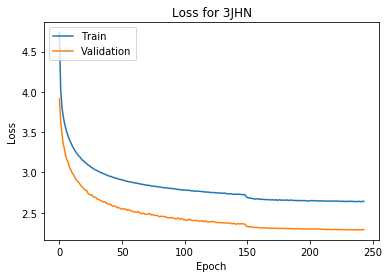

In [9]:
from datetime import datetime

mol_types=df_train["type"].unique()
cv_score=[]
cv_score_total=0
epoch_n = 300
verbose = 1
batch_size = 514
    
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain =True


# Set up GPU preferences
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config) 
K.set_session(sess)

start_time=datetime.now()

# Loop through each molecule type
for mol_type in mol_types:
    model_name_rd = ('molecule_model_%s.hdf5' % mol_type)
    model_name_wrt = ('molecule_model_%s.hdf5' % mol_type)
    print('Training %s' % mol_type, 'out of', mol_types, '\n')
    
    df_train_=df_train[df_train["type"]==mol_type]
    df_test_=df_test[df_test["type"]==mol_type]
    
    # Here's our best features.  We think.
    input_features=["x_0","y_0","z_0","x_1","y_1","z_1","c_x","c_y","c_z",
                    'x_closest_0','y_closest_0','z_closest_0','x_closest_1','y_closest_1','z_closest_1',
                    "distance","distance_center0","distance_center1", "distance_c0","distance_c1","distance_f0","distance_f1",
                    "cos_c0_c1","cos_f0_f1","cos_center0_center1","cos_c0","cos_c1","cos_f0","cos_f1","cos_center0","cos_center1",
                    "atom_n"
                   ]
    
    # Standard Scaler from sklearn does seem to work better here than other Scalers
    input_data=StandardScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))
    
    target_data=df_train_.loc[:,"scalar_coupling_constant"].values
    target_data_1=df_train_.loc[:,["charge_0","charge_1"]]
    target_data_2=df_train_.loc[:,["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"]]
    target_data_3=df_train_.loc[:,["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"]]
    
    #following parameters should be adjusted to control the loss function
    #if all parameters are zero, attractors do not work. (-> simple neural network)
    m1=1
    m2=4
    m3=1
    target_data_1=m1*(StandardScaler().fit_transform(target_data_1))
    target_data_2=m2*(StandardScaler().fit_transform(target_data_2))
    target_data_3=m3*(StandardScaler().fit_transform(target_data_3))
    
    # Simple split to provide us a validation set to do our CV checks with
    train_index, cv_index = train_test_split(np.arange(len(df_train_)),random_state=111, test_size=0.1)
    
    # Split all our input and targets by train and cv indexes
    train_input=input_data[train_index]
    cv_input=input_data[cv_index]
    train_target=target_data[train_index]
    cv_target=target_data[cv_index]
    train_target_1=target_data_1[train_index]
    cv_target_1=target_data_1[cv_index]
    train_target_2=target_data_2[train_index]
    cv_target_2=target_data_2[cv_index]
    train_target_3=target_data_3[train_index]
    cv_target_3=target_data_3[cv_index]
    test_input=input_data[len(df_train_):,:]

    # Build the Neural Net
    nn_model=create_nn_model(train_input.shape[1])
    
    # If retrain==False, then we load a previous saved model as a starting point.
    if not retrain:
        nn_model = load_model(model_name_rd)
        
    nn_model.compile(loss='mae', optimizer=Adam())#, metrics=[auc])
    
    # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=8,verbose=1, mode='auto', restore_best_weights=True)
    # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
    rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=7, min_lr=1e-6, mode='auto', verbose=1)
    # Save the best value of the model for future use
    sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True, period=1)

    history = nn_model.fit(train_input,[train_target,train_target_1,train_target_2,train_target_3], 
            validation_data=(cv_input,[cv_target,cv_target_1,cv_target_2,cv_target_3]), 
            callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)
    
    cv_predict=nn_model.predict(cv_input)
    plot_history(history, mol_type)
    
    accuracy=np.mean(np.abs(cv_target-cv_predict[0][:,0]))
    cv_score.append(np.log(accuracy))
    cv_score_total+=np.log(accuracy)
    
    # Predict on the test data set using our trained model
    test_predict=nn_model.predict(test_input)
    
    # for each molecule type we'll grab the predicted values
    test_prediction[df_test["type"]==mol_type]=test_predict[0][:,0]
    K.clear_session()

cv_score_total/=len(mol_types)

In [10]:
def submit(predictions):
    submit = pd.read_csv('../input/sample_submission.csv')
    print(len(submit), len(predictions))   
    submit["scalar_coupling_constant"] = predictions
    submit.to_csv("workingsubmission-test3.csv", index=False)
submit(test_prediction)

print ('Total training time: ', datetime.now() - start_time)

i=0
for mol_type in mol_types: 
    print(mol_type,": cv score is ",cv_score[i])
    i+=1
print("total cv score is",cv_score_total)

2505542 2505542
Total training time:  8:51:46.852074
1JHC : cv score is  0.7032225305268082
2JHH : cv score is  -1.0734813105790668
1JHN : cv score is  0.1128866215495241
2JHN : cv score is  -1.383094998433715
2JHC : cv score is  -0.4551608977192807
3JHH : cv score is  -1.0613778196949926
3JHC : cv score is  -0.43936078453103955
3JHN : cv score is  -1.6183231913420735
total cv score is -0.6518362312779795
